# HOPP Käppyrää

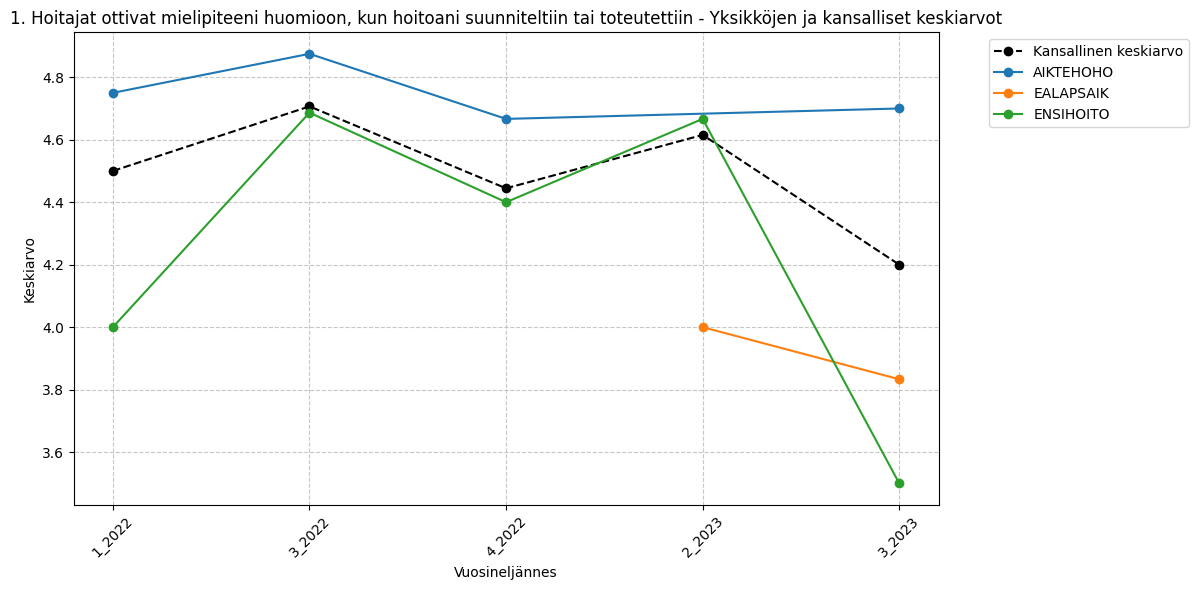

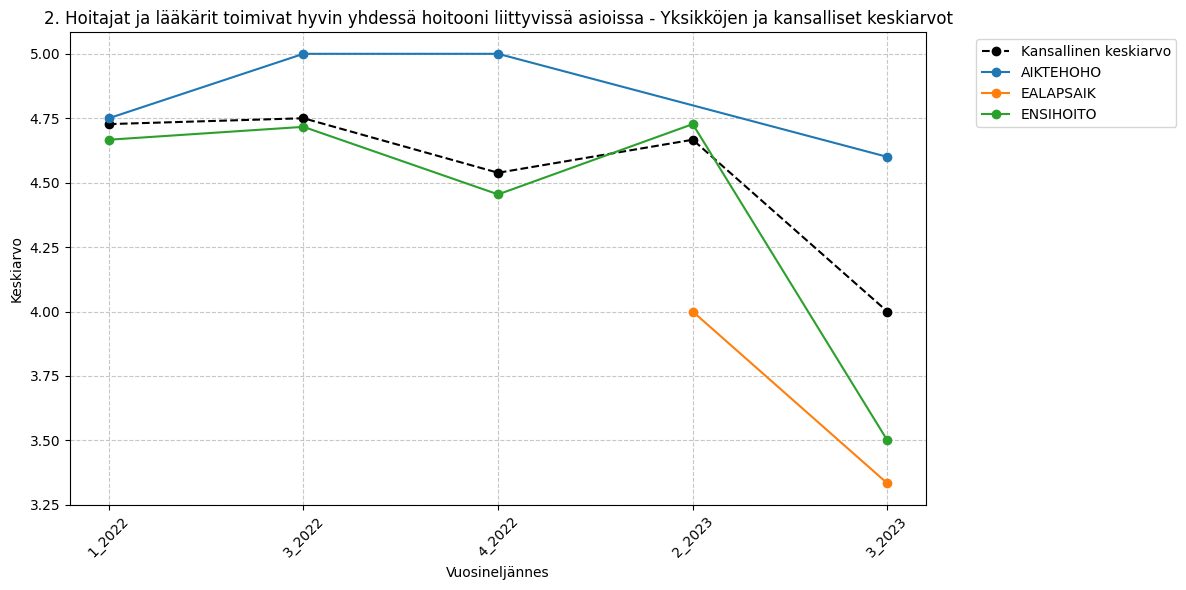

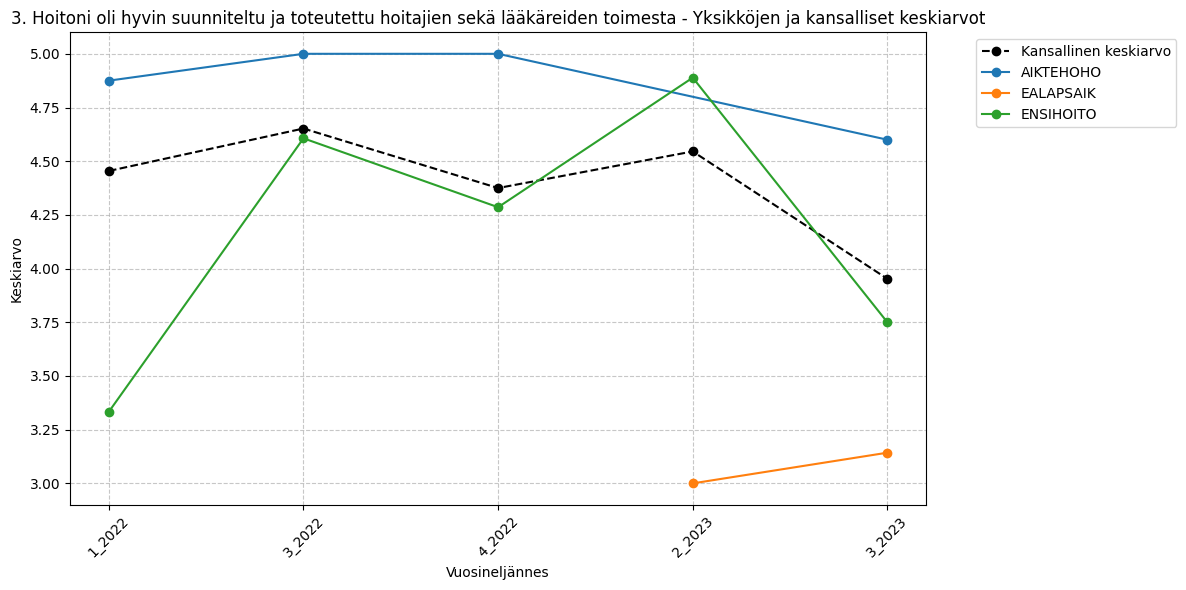

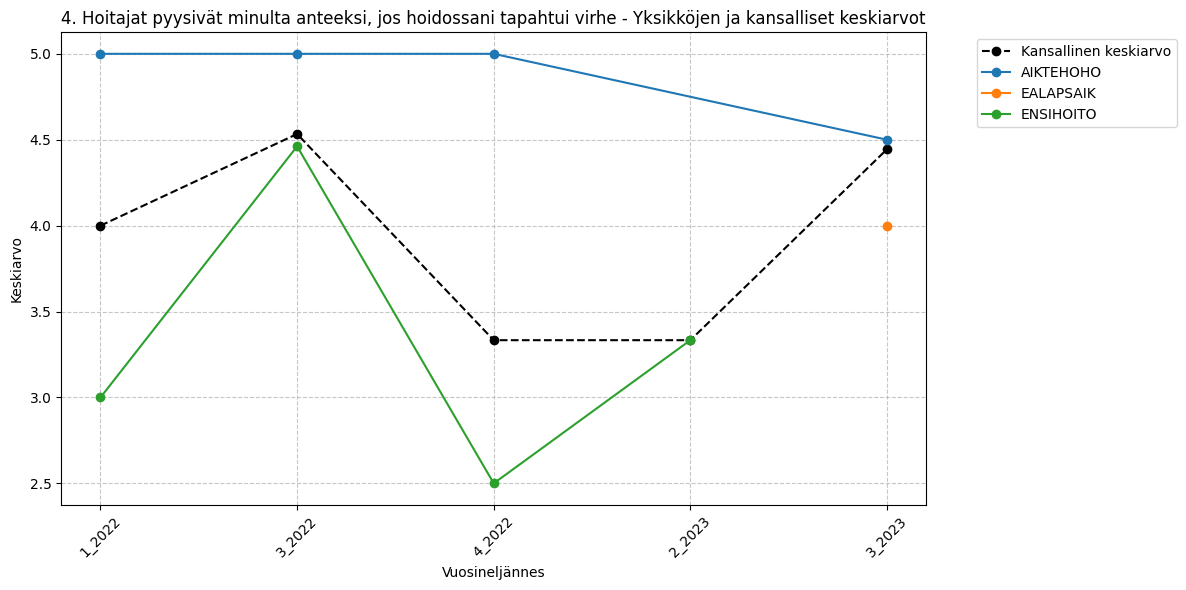

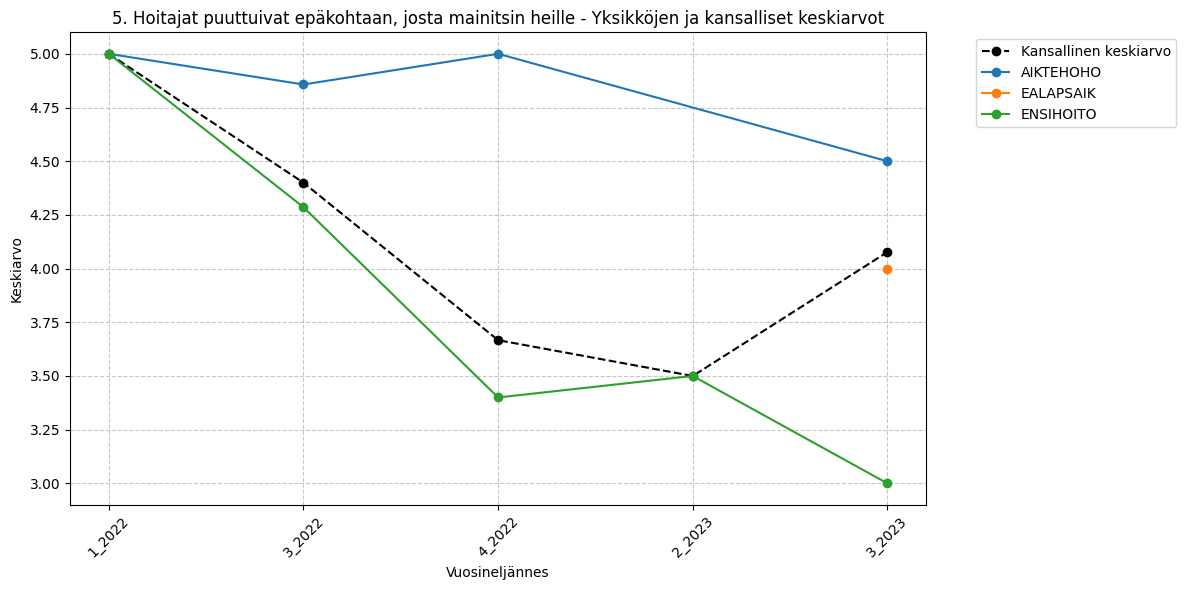

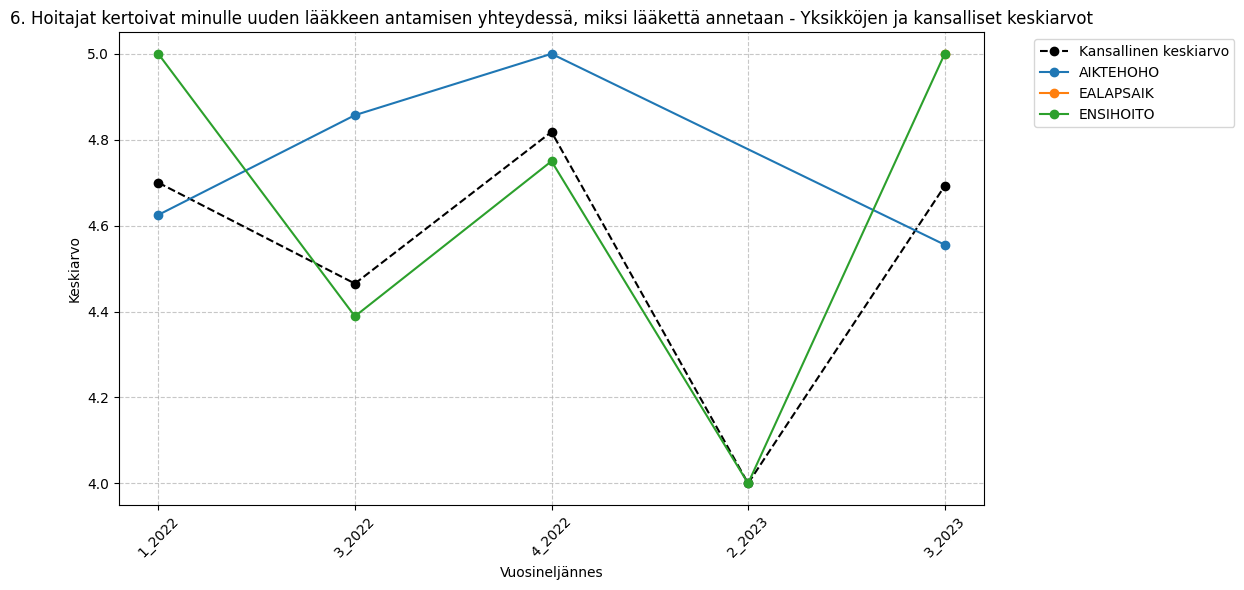

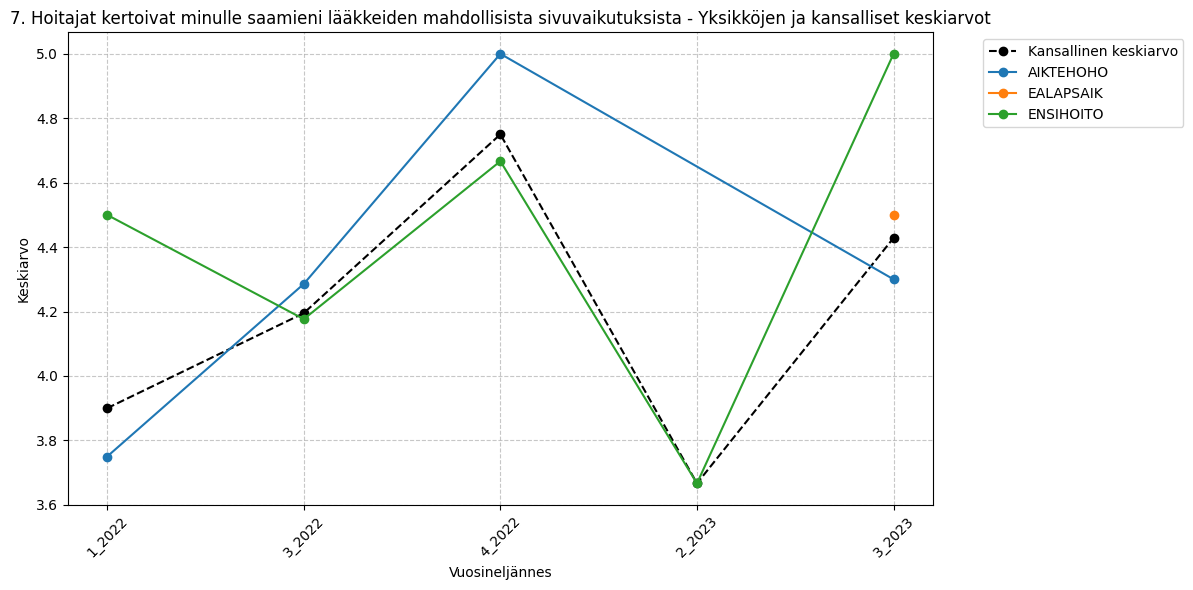

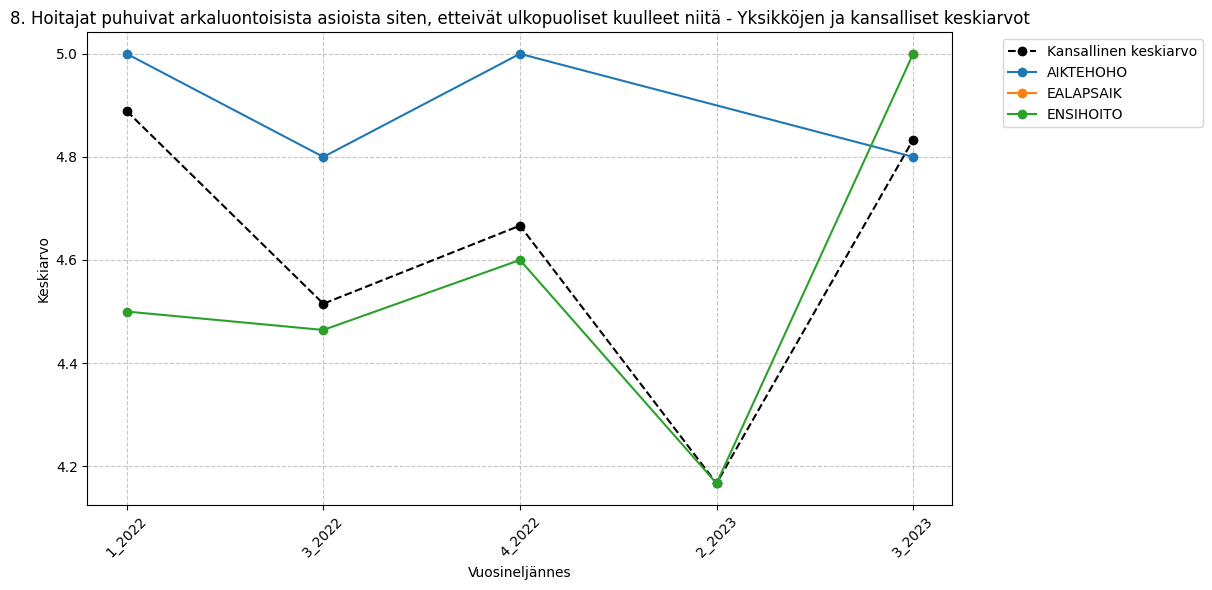

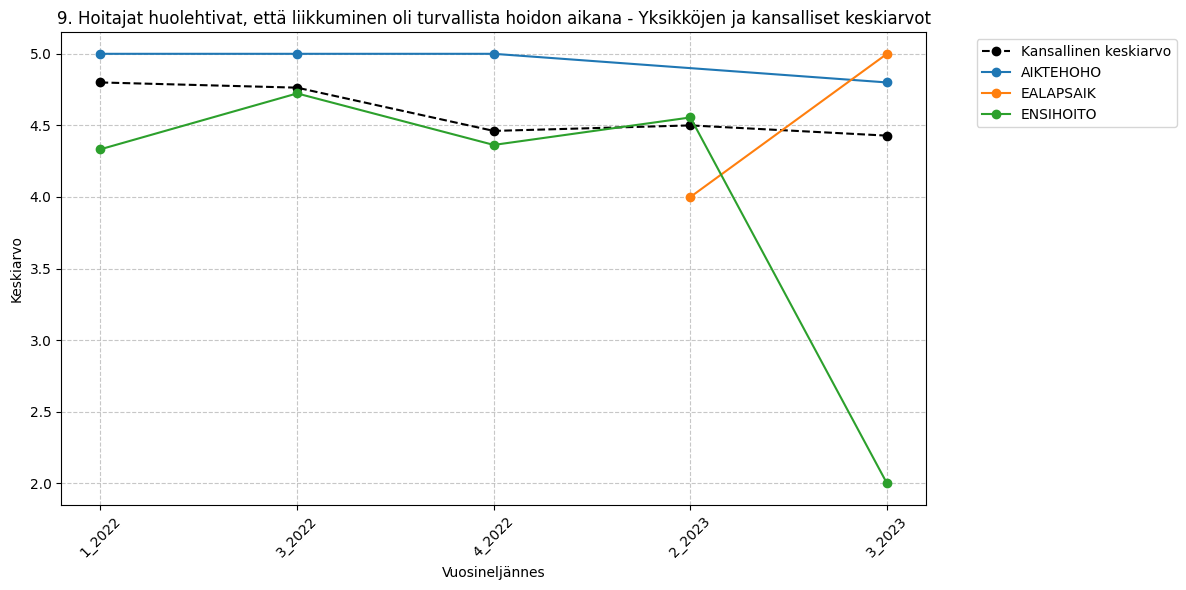

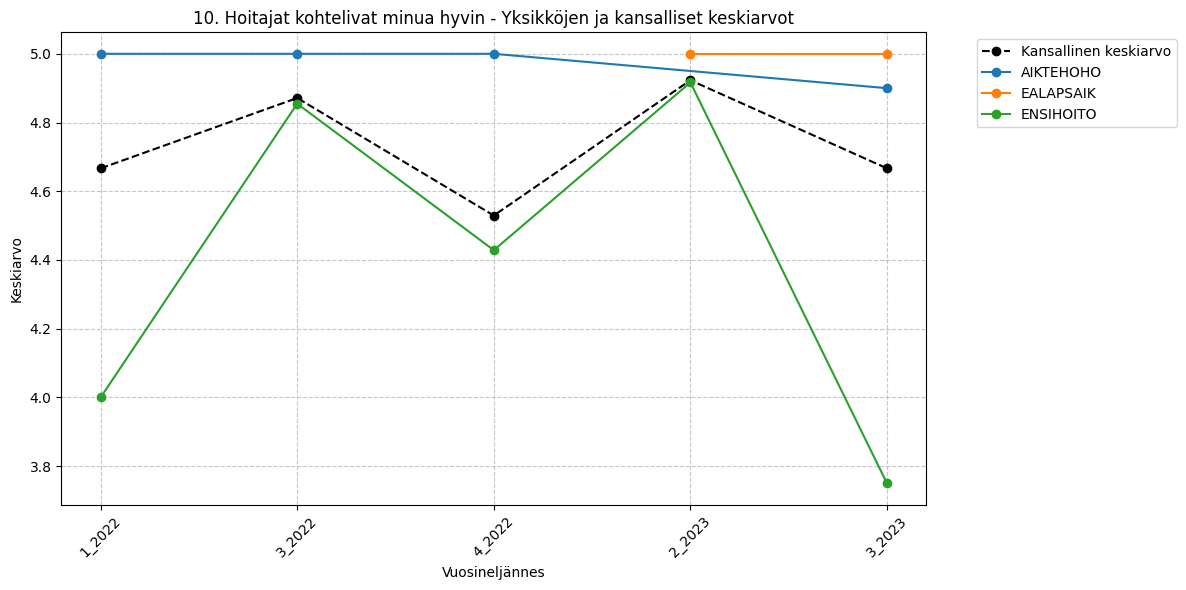

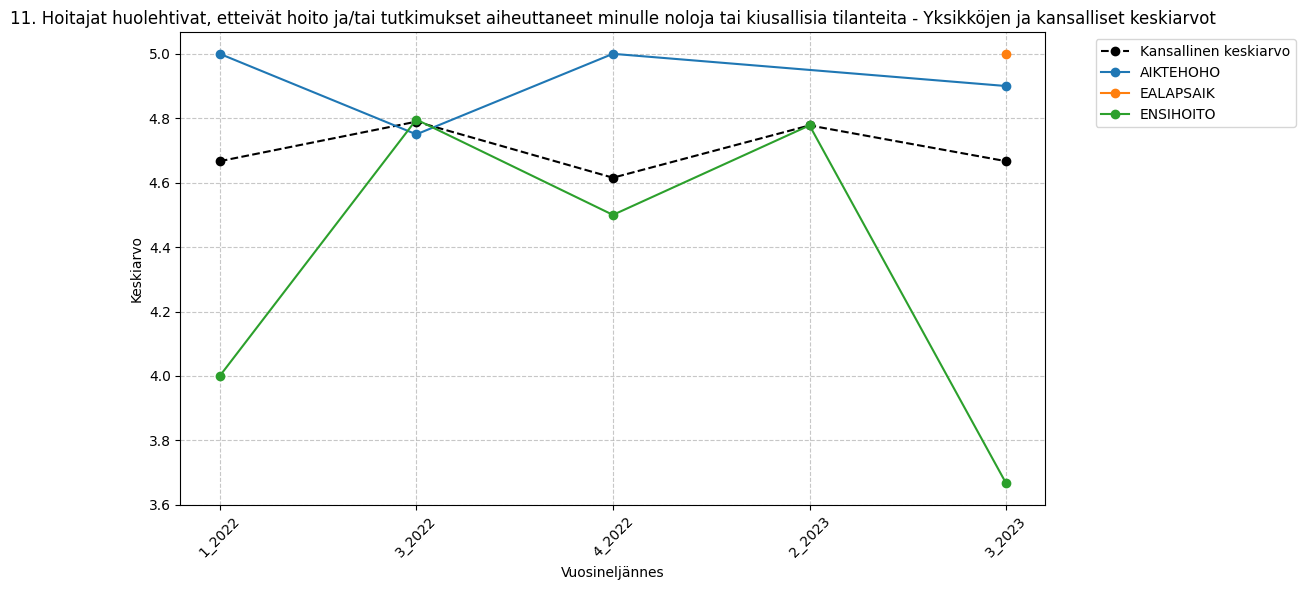

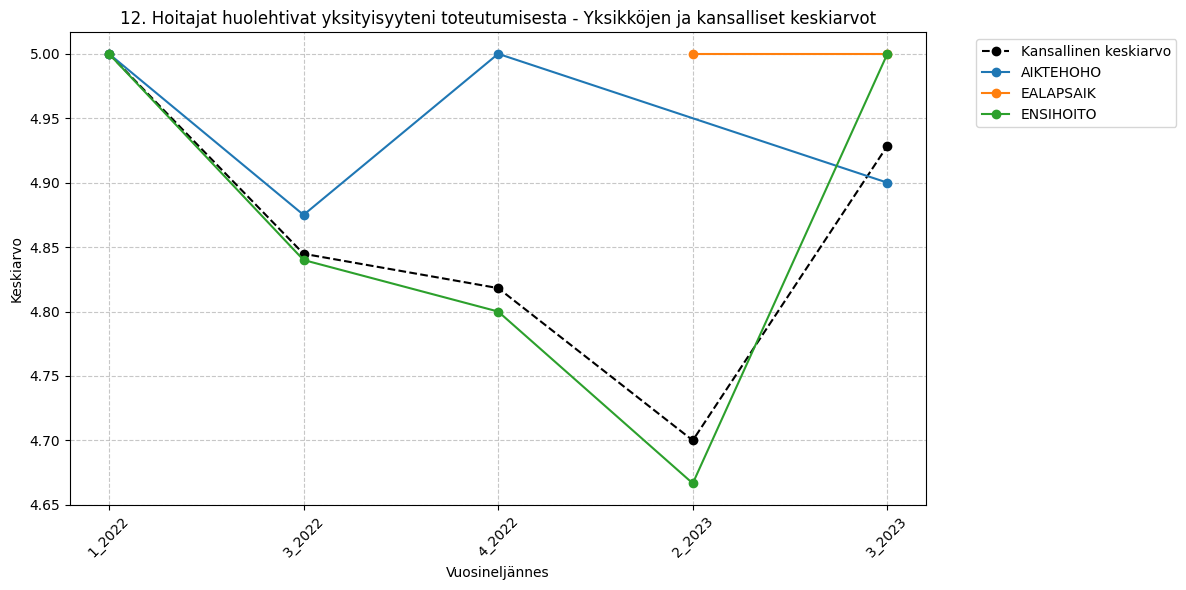

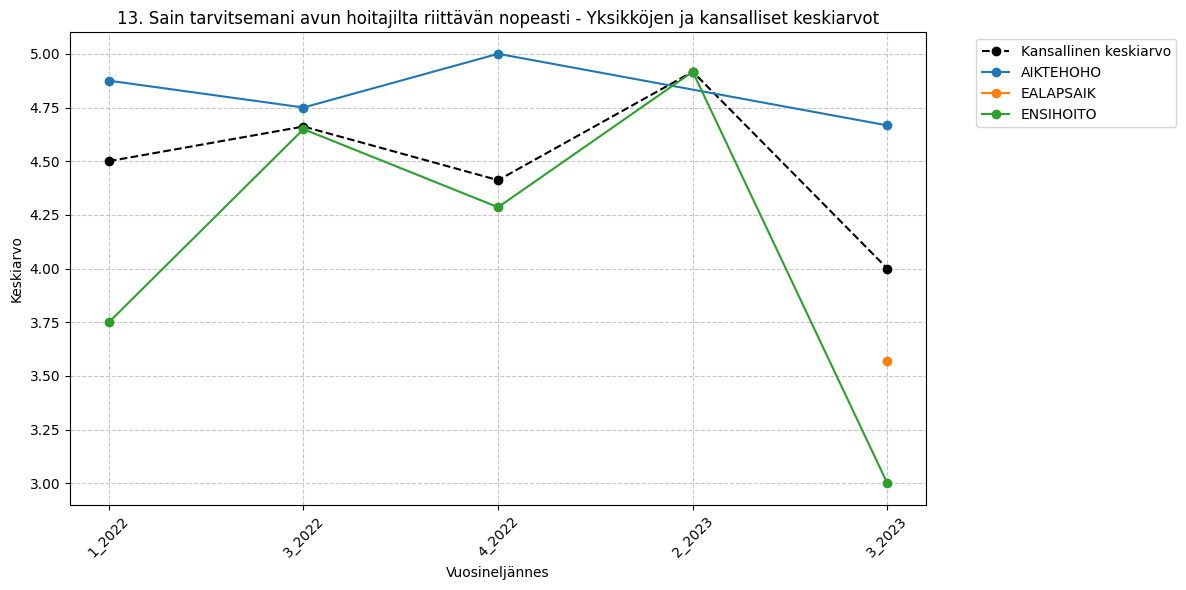

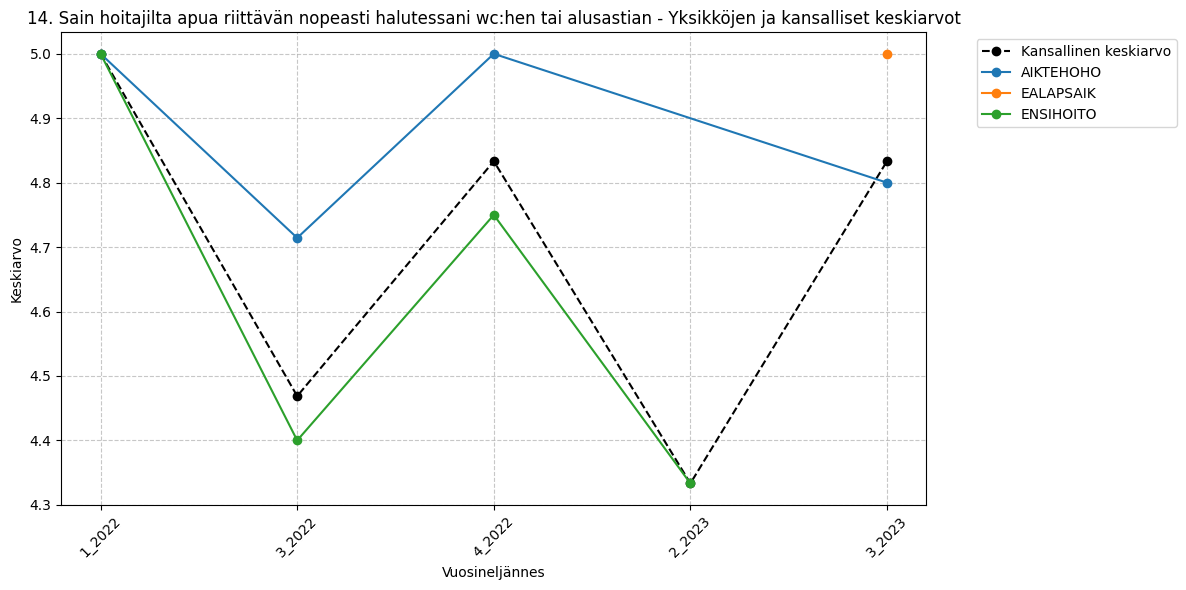

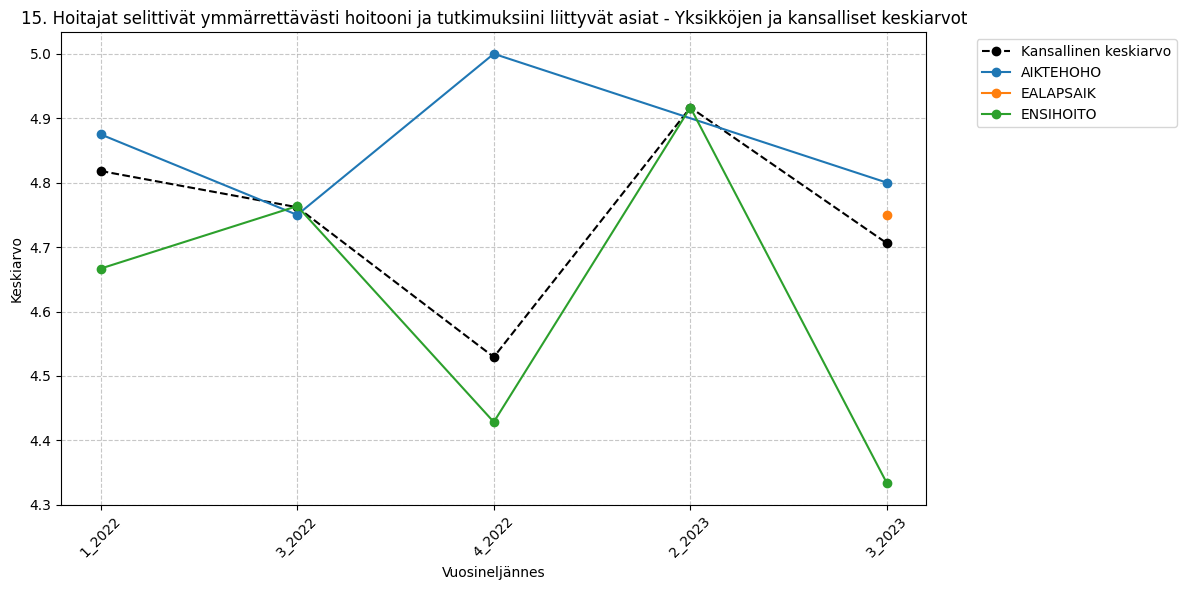

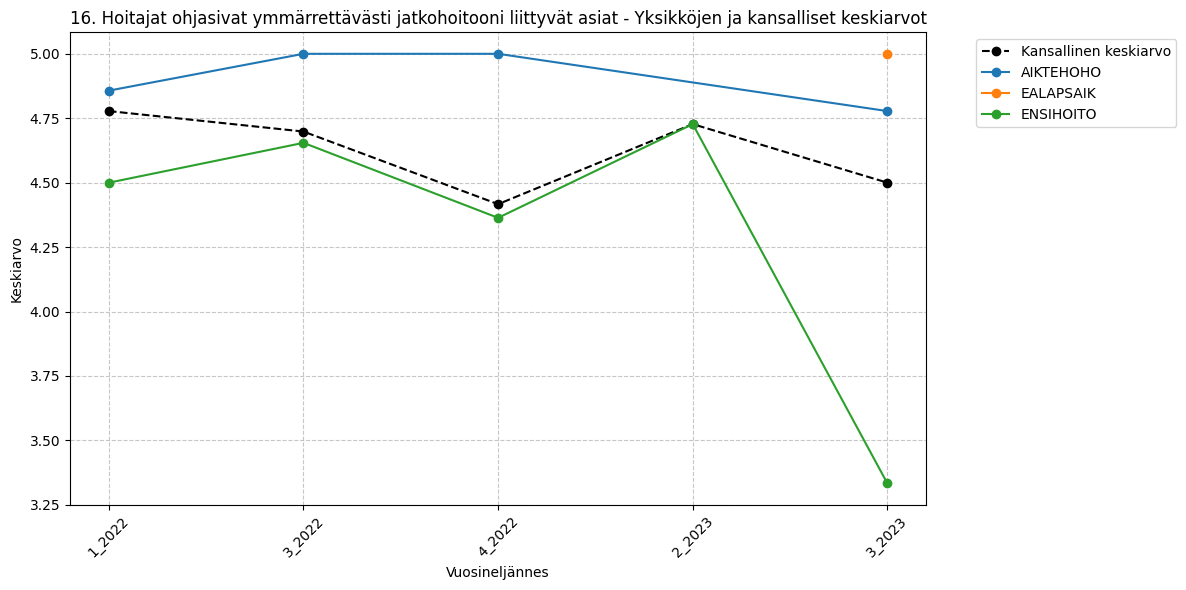

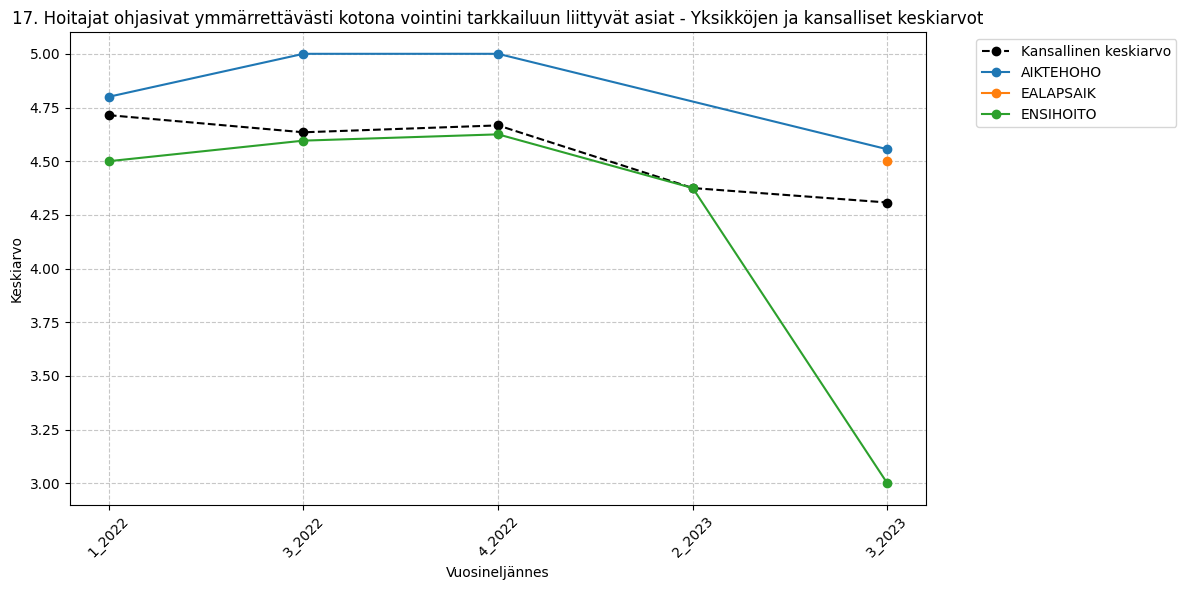

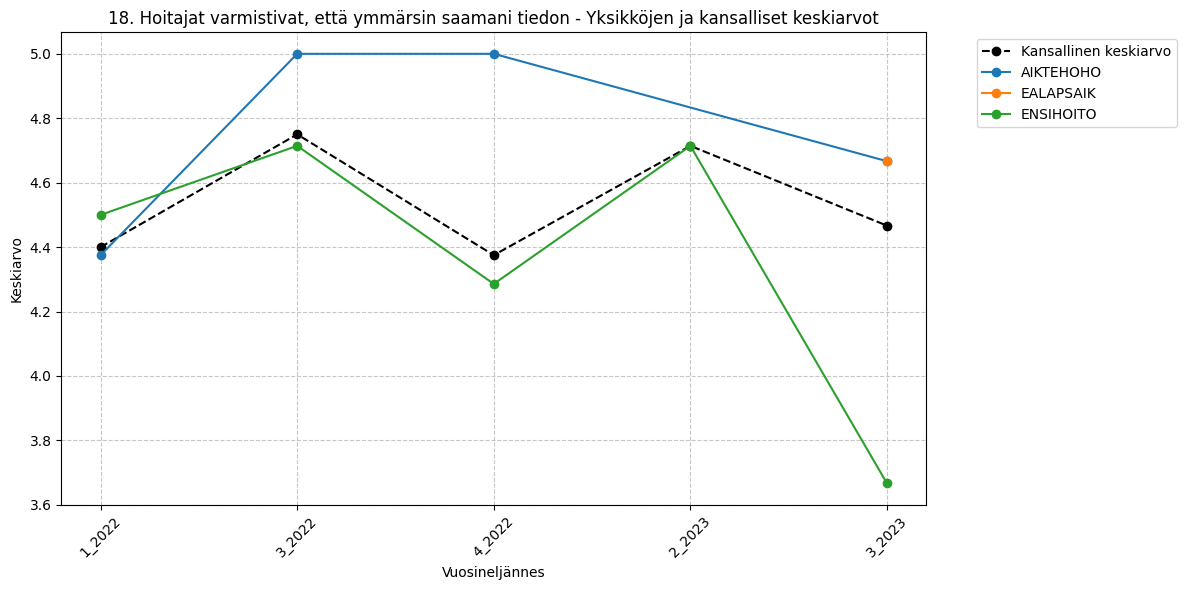

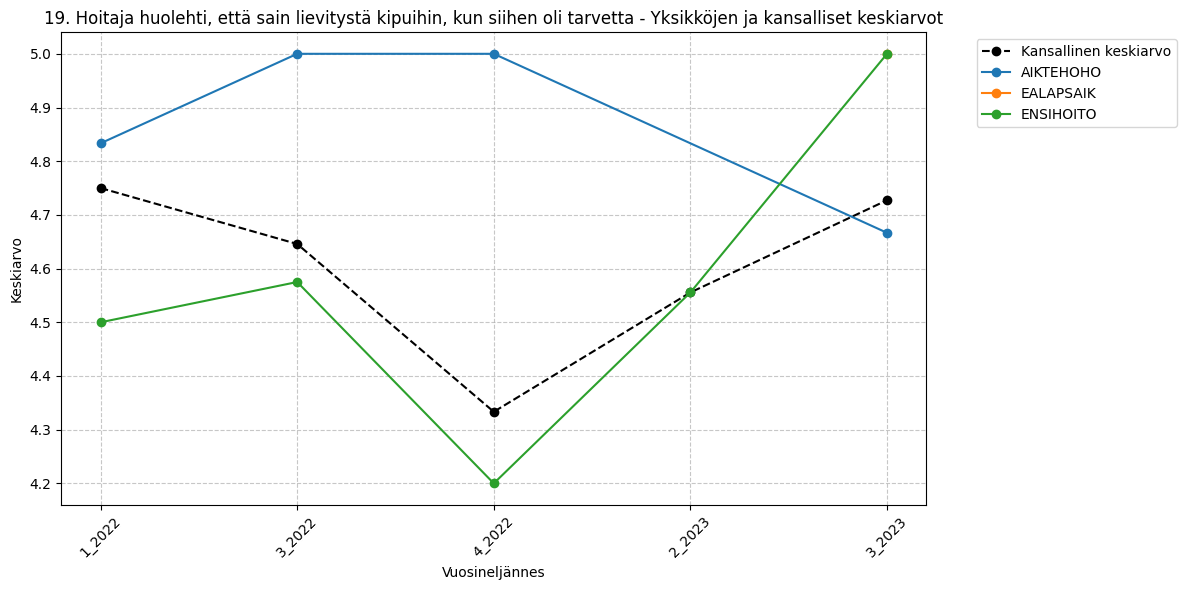

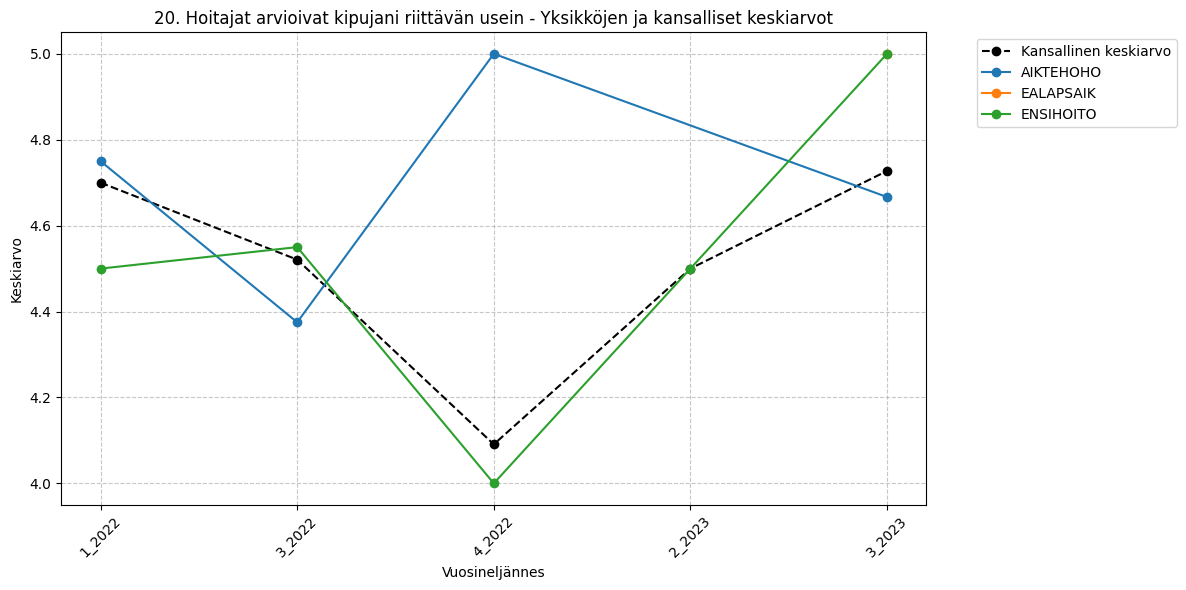

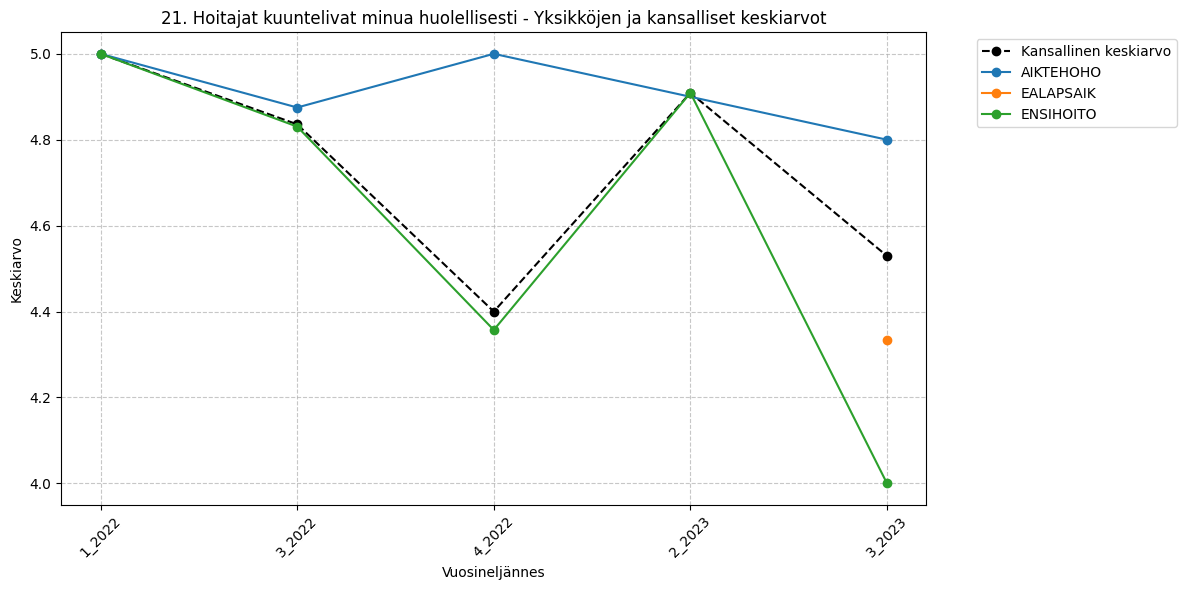

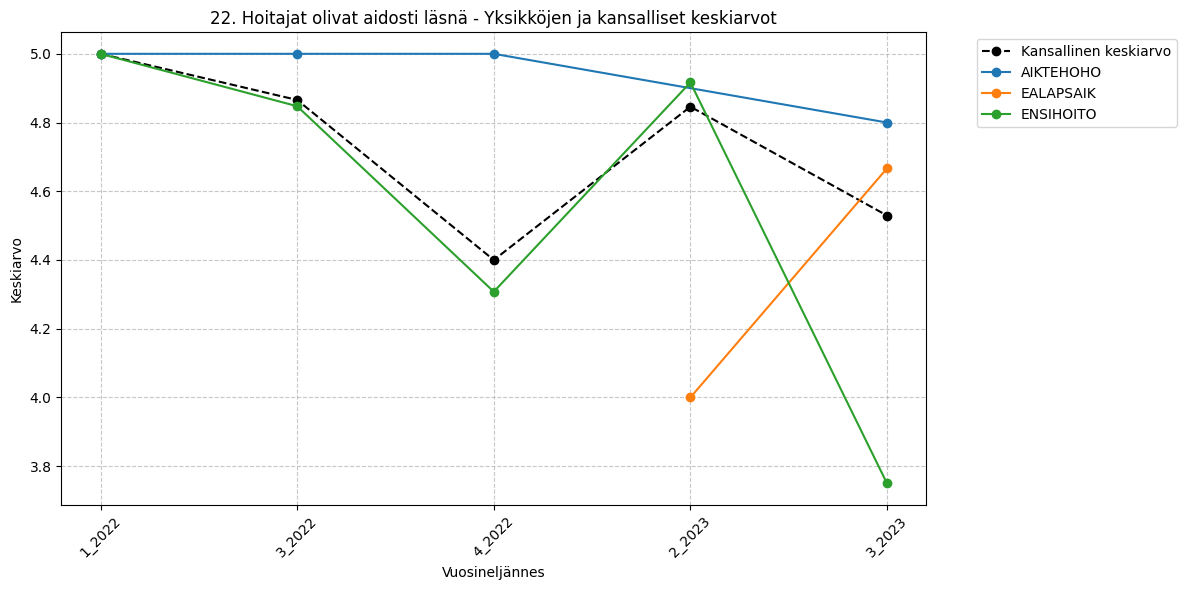

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Määritä polku kansioon, jossa tiedostot sijaitsevat
data_folder = "C:/Users/jonik/code/Projekti_2/project_sigma/data/HOPP"

# Tiedostojen polut
file_paths = [
    f"{data_folder}/117_HOpp-Q2_2023.xlsx",
    f"{data_folder}/117_HOpp-Q3_2023.xlsx",
    f"{data_folder}/HoPP_Q1_Kaks_Tiedonkeruulomake_kansallinen_2022.xlsx",
    f"{data_folder}/HoPP_Q3_KAKS_Tiedonkeruulomake_kansallinen_2022.xlsx",
    f"{data_folder}/HoPP_Q4_KAKS_Tiedonkeruulomake_kansallinen_2022.xlsx",
]

# Lataa ja yhdistä data
data_frames = []
for file in file_paths:
    df = pd.read_excel(file)
    data_frames.append(df)

data = pd.concat(data_frames, ignore_index=True)

# Määritä numeeriset sarakkeet (kysymykset 1-22)
numeric_columns = [col for col in data.columns if col.startswith(tuple([f"{i}." for i in range(1, 23)]))]

# Suodata vain halutut yksiköt
selected_units = ["AIKTEHOHO", "EALAPSAIK", "ENSIHOITO"]
data = data[data["YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä"].isin(selected_units)]

# Korvaa 'E' arvot NaN:lla ja muunna numerot
data[numeric_columns] = data[numeric_columns].replace('E', pd.NA)
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Ryhmittele data yksikön ja vuosineljänneksen mukaan
unit_avg = data.groupby([
    'YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä',
    'KVARTAALI JA VUOSI\n(ESIM. 1_2020)'
])[numeric_columns].mean()

# Laske kansalliset keskiarvot
national_avg = data.groupby('KVARTAALI JA VUOSI\n(ESIM. 1_2020)')[numeric_columns].mean()

# Määritellään järjestysfunktio
def sort_quarters(df):
    def quarter_to_float(q):
        quarter, year = q.split('_')
        return float(year) + (float(quarter) - 1) / 4

    if isinstance(df.index, pd.MultiIndex):
        quarter_level = 1
        sorted_quarters = sorted(df.index.levels[quarter_level], key=quarter_to_float)
        return df.reindex(level=quarter_level, labels=sorted_quarters)
    else:
        return df.reindex(sorted(df.index, key=quarter_to_float))

# Järjestä keskiarvot
national_avg = sort_quarters(national_avg)
unit_avg = sort_quarters(unit_avg)

# Visualisoi tulokset (vain kerran)
for question in numeric_columns:
    plt.figure(figsize=(12, 6))
    
    # Kansalliset keskiarvot
    plt.plot(
        national_avg.index,
        national_avg[question],
        label="Kansallinen keskiarvo",
        color="black",
        linestyle="--",
        marker='o'
    )
    
    # Yksikköjen keskiarvot
    for unit in selected_units:
        if unit in unit_avg.index.get_level_values(0):
            unit_data = unit_avg.loc[unit]
            plt.plot(
                unit_data.index,
                unit_data[question],
                label=unit,
                marker='o'
            )
    
    plt.title(f"{question} - Yksikköjen ja kansalliset keskiarvot")
    plt.xlabel("Vuosineljännes")
    plt.ylabel("Keskiarvo")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [2]:
import ipywidgets as widgets
from ipywidgets import interact


def create_hopp_table(data, unit, quarter):
    # Suodata data yksikön mukaan
    unit_data = data[data["YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä"] == unit]
    quarter_data = unit_data[unit_data["KVARTAALI JA VUOSI\n(ESIM. 1_2020)"] == quarter]
    
    # Laske kansallinen keskiarvo kyseiselle vuosineljännekselle
    national_data = data[data["KVARTAALI JA VUOSI\n(ESIM. 1_2020)"] == quarter]
    national_avg = national_data[numeric_columns].mean()
    
    # Luo yhteenvetotaulukko
    summary = pd.DataFrame({
        'Rivikotsikot': ['Aikuiset'] * len(numeric_columns),
        'Luokittelukoodi': [unit] * len(numeric_columns),
        'Vuosineljännes': [quarter] * len(numeric_columns),
        'Kysymys': numeric_columns,
        'Kyselyitä': quarter_data[numeric_columns].notna().sum(),
        'Vastauksia': quarter_data[numeric_columns].count(),
        'Keskiarvo': quarter_data[numeric_columns].mean().round(2),
        'Kansallinen keskiarvo': national_avg.round(2)
    })
    
    return summary

# Hae uniikit vuosineljännekset ja järjestä ne
quarters = sorted(data["KVARTAALI JA VUOSI\n(ESIM. 1_2020)"].unique())
units = ["AIKTEHOHO", "EALAPSAIK", "ENSIHOITO"]

# Luo interaktiivinen näkymä
def interactive_table(quarter, unit):
    summary = create_hopp_table(data, unit, quarter)
    
    # Muotoile taulukko ilman hide_index
    styled_table = summary.style.set_properties(**{
        'font-size': '11pt',
        'font-family': 'Arial',
        'text-align': 'left',
        'padding': '5px'
    }).format({
        'Keskiarvo': '{:.2f}',
        'Kansallinen keskiarvo': '{:.2f}'
    })
    
    # Näytetään taulukko ilman indeksiä
    display(styled_table)

# Luo pudotusvalikot
quarter_dropdown = widgets.Dropdown(
    options=quarters,
    description='Vuosineljännes:',
    style={'description_width': 'initial'}
)

unit_dropdown = widgets.Dropdown(
    options=units,
    description='Yksikkö:',
    style={'description_width': 'initial'}
)

# Näytä interaktiivinen taulukko
interact(interactive_table, quarter=quarter_dropdown, unit=unit_dropdown)

interactive(children=(Dropdown(description='Vuosineljännes:', options=('1_2022', '2_2023', '3_2022', '3_2023',…

<function __main__.interactive_table(quarter, unit)>

In [3]:
print(data.columns)



Index(['ORGANISAATIOKOODI (kolme numeroa)',
       'YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä',
       'KVARTAALI JA VUOSI\n(ESIM. 1_2020)',
       '1. Hoitajat ottivat mielipiteeni huomioon, kun hoitoani suunniteltiin tai toteutettiin',
       '2. Hoitajat ja lääkärit toimivat hyvin yhdessä hoitooni liittyvissä asioissa',
       '3. Hoitoni oli hyvin suunniteltu ja toteutettu hoitajien sekä lääkäreiden toimesta',
       '4. Hoitajat pyysivät minulta anteeksi, jos hoidossani tapahtui virhe',
       '5. Hoitajat puuttuivat epäkohtaan, josta mainitsin heille',
       '6. Hoitajat kertoivat minulle uuden lääkkeen antamisen yhteydessä, miksi lääkettä annetaan',
       '7. Hoitajat kertoivat minulle saamieni lääkkeiden mahdollisista sivuvaikutuksista',
       '8. Hoitajat puhuivat arkaluontoisista asioista siten, etteivät ulkopuoliset kuulleet niitä',
       '9. Hoitajat huolehtivat, että liikkuminen oli turvallista hoidon aikana',
       '10. Hoitajat kohtelivat minua hyv

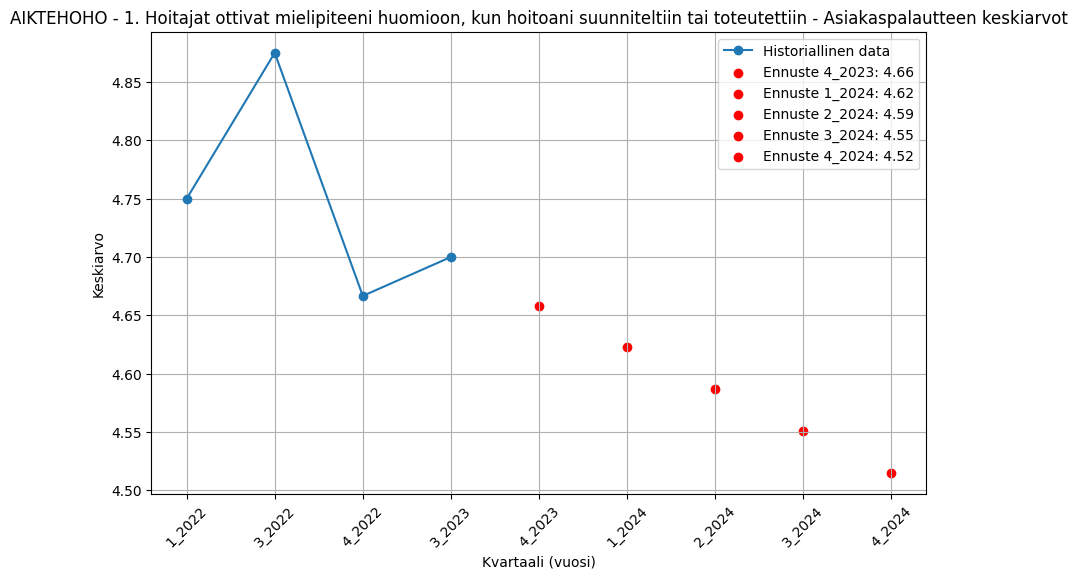

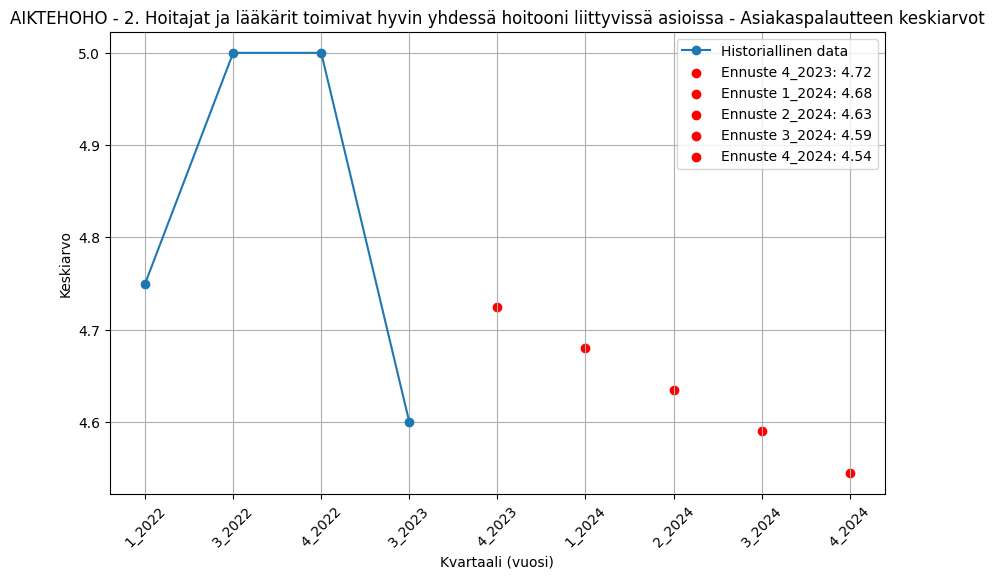

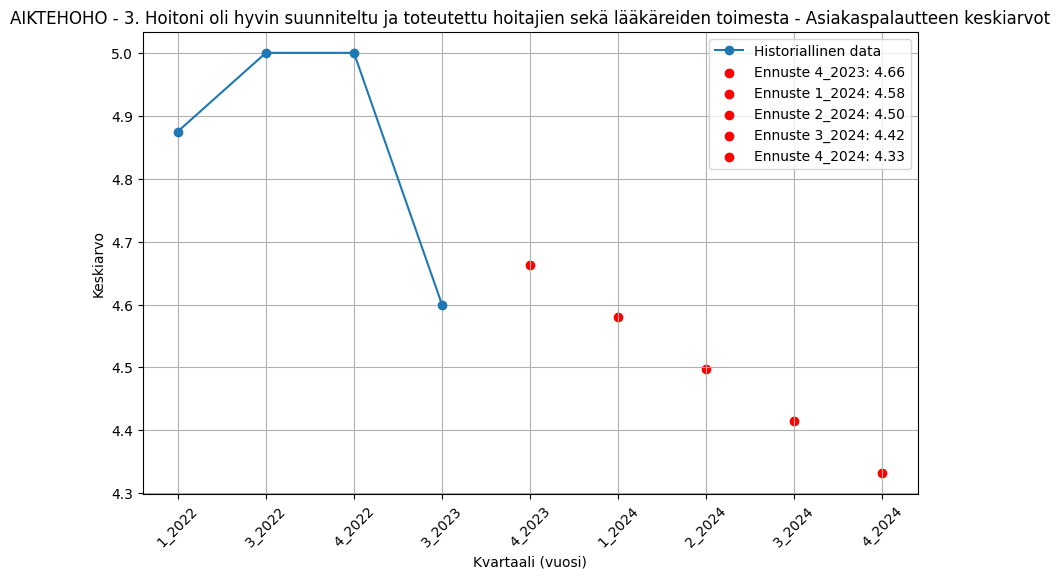

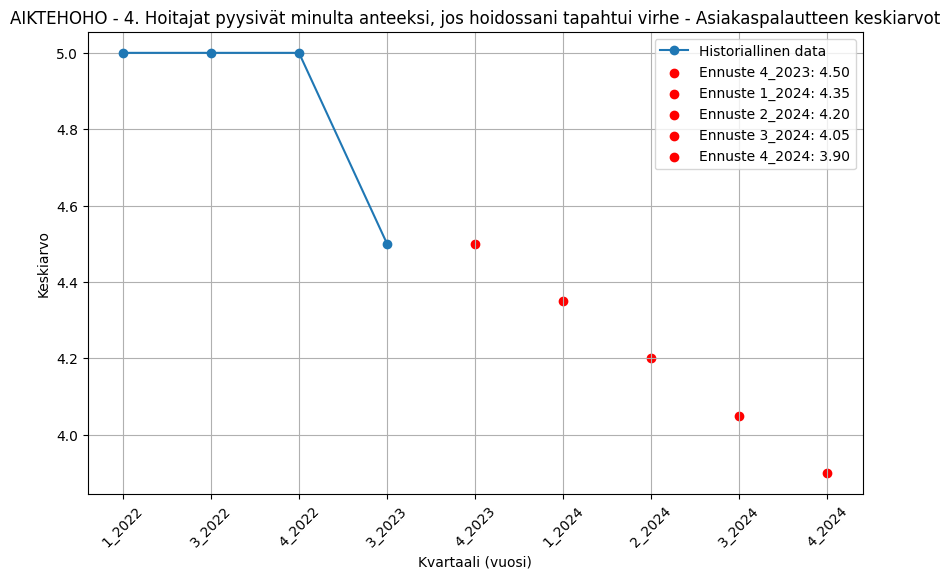

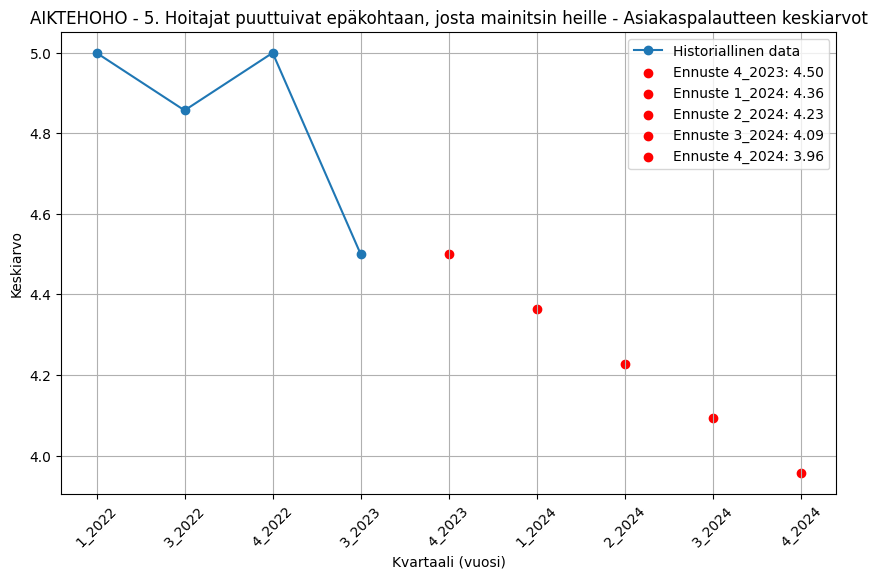

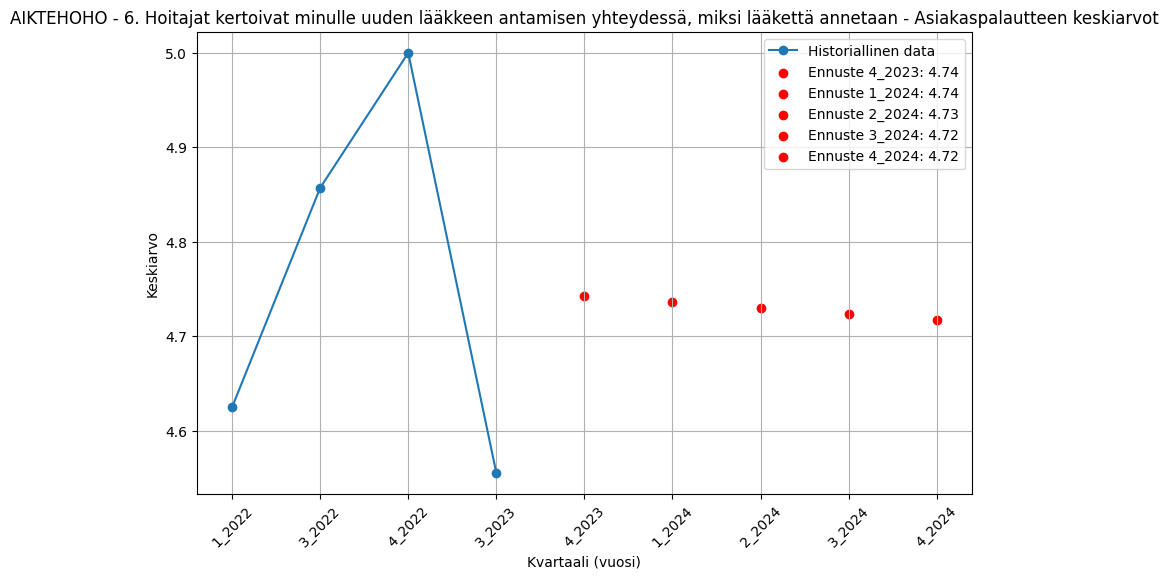

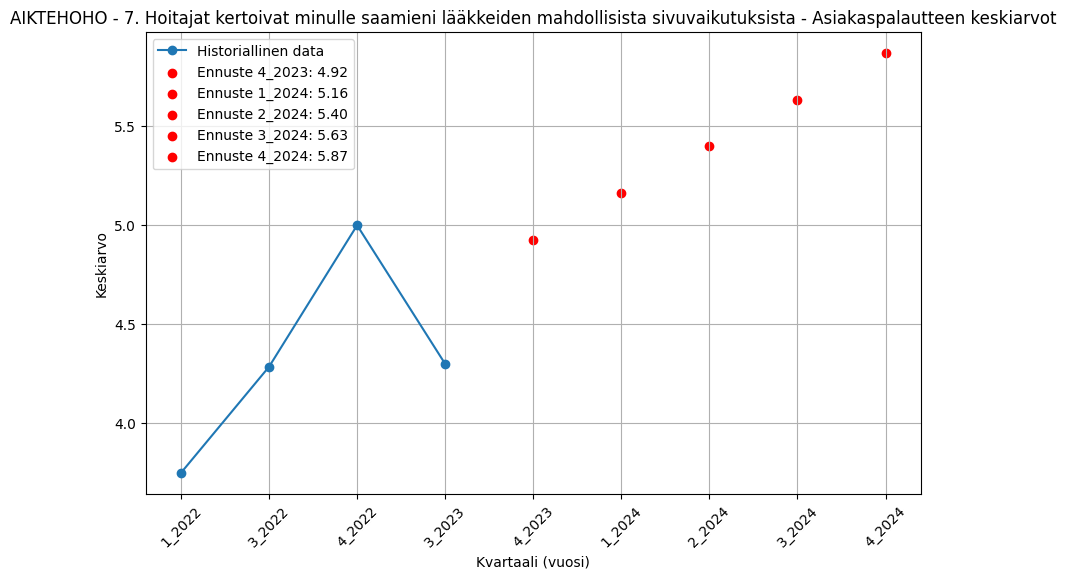

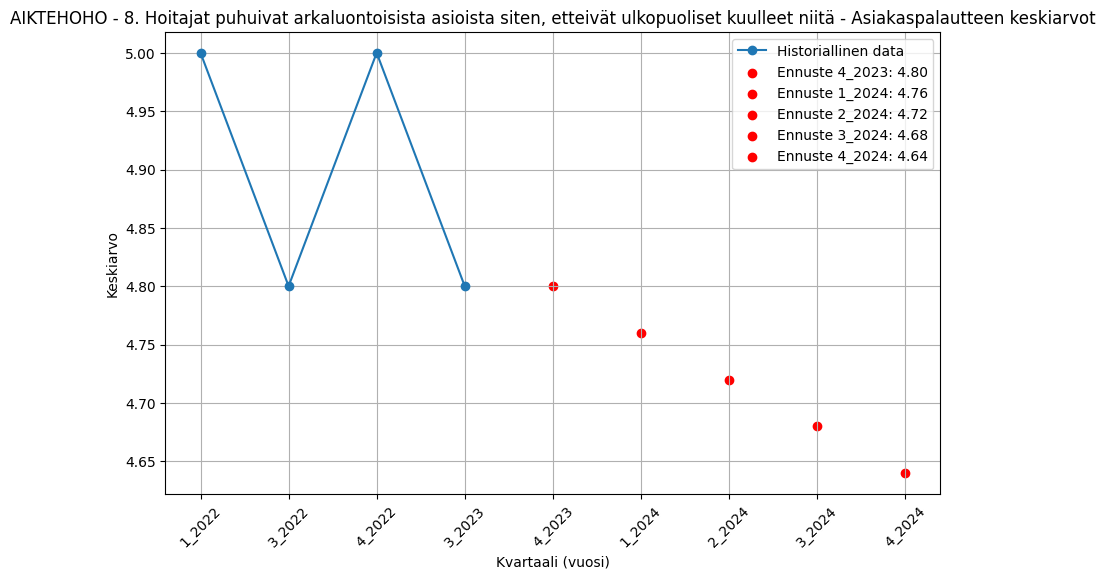

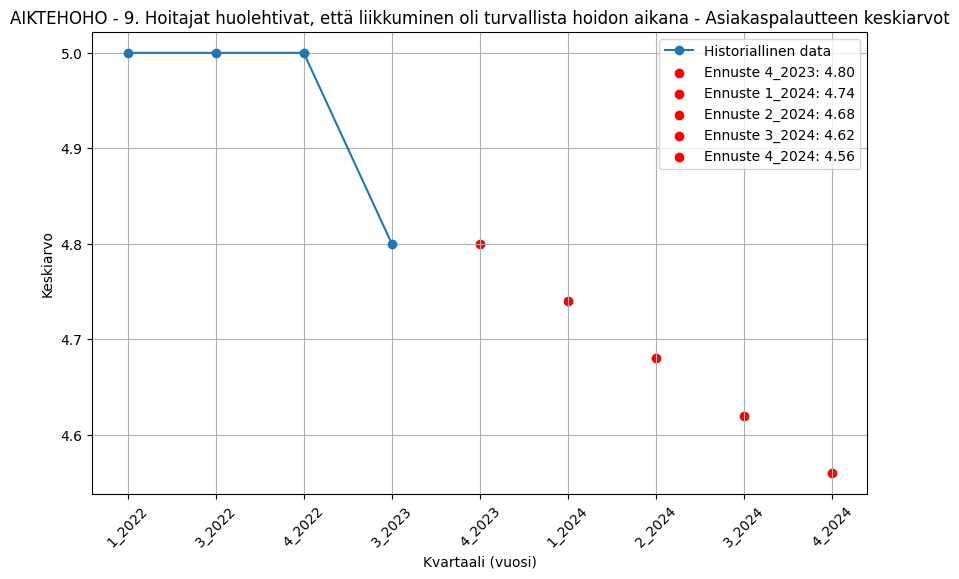

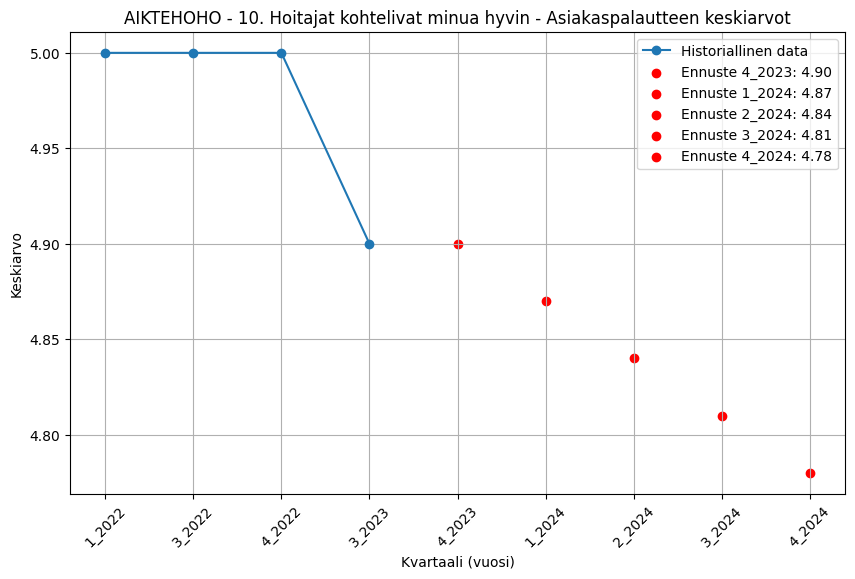

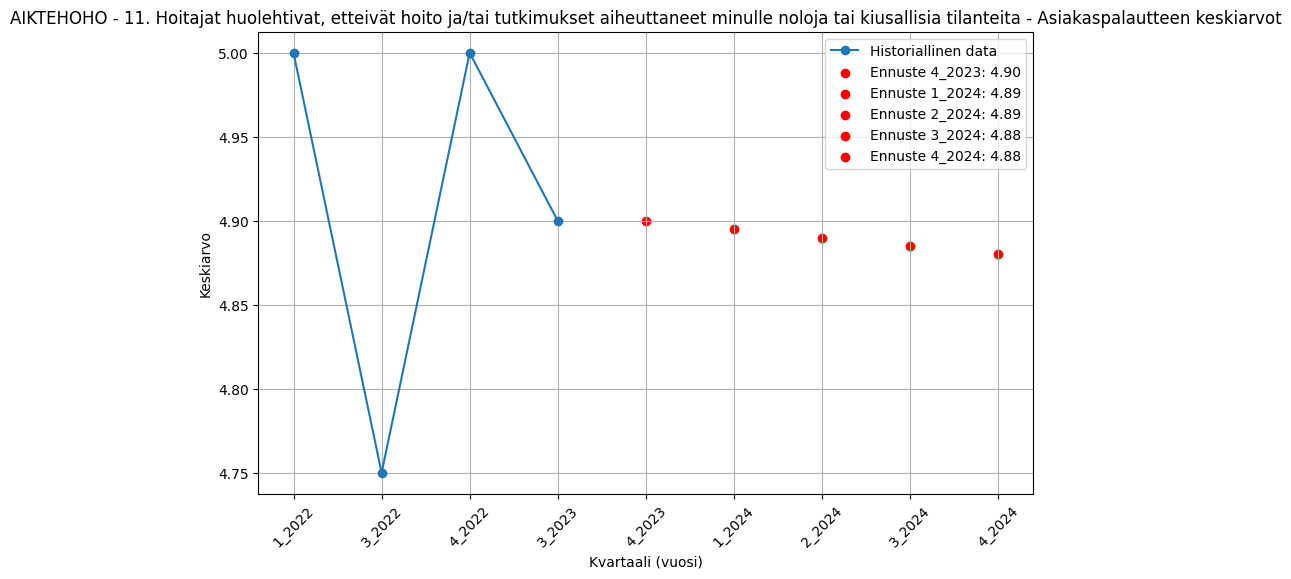

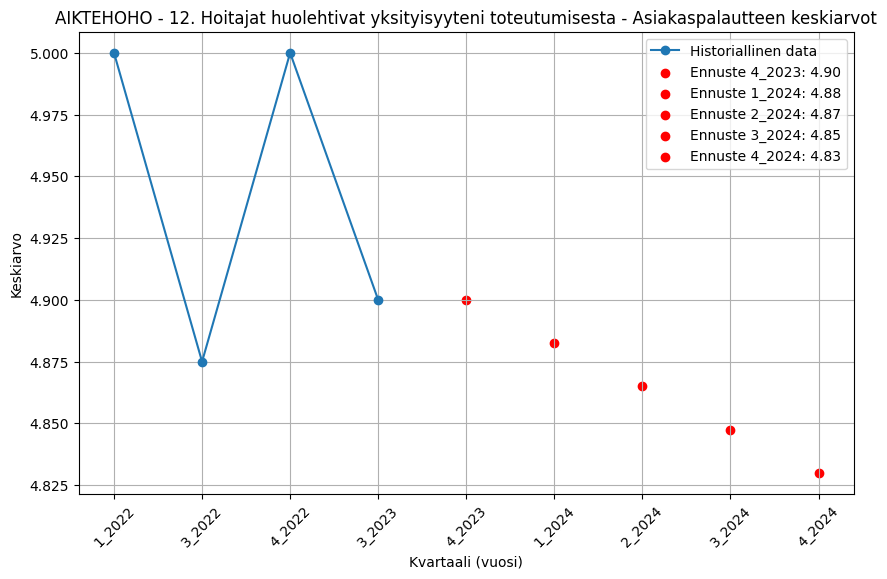

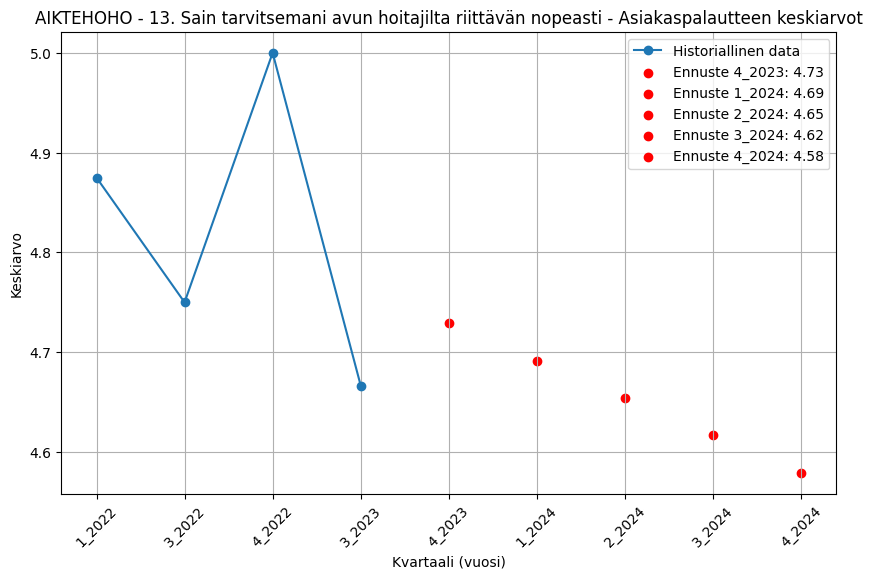

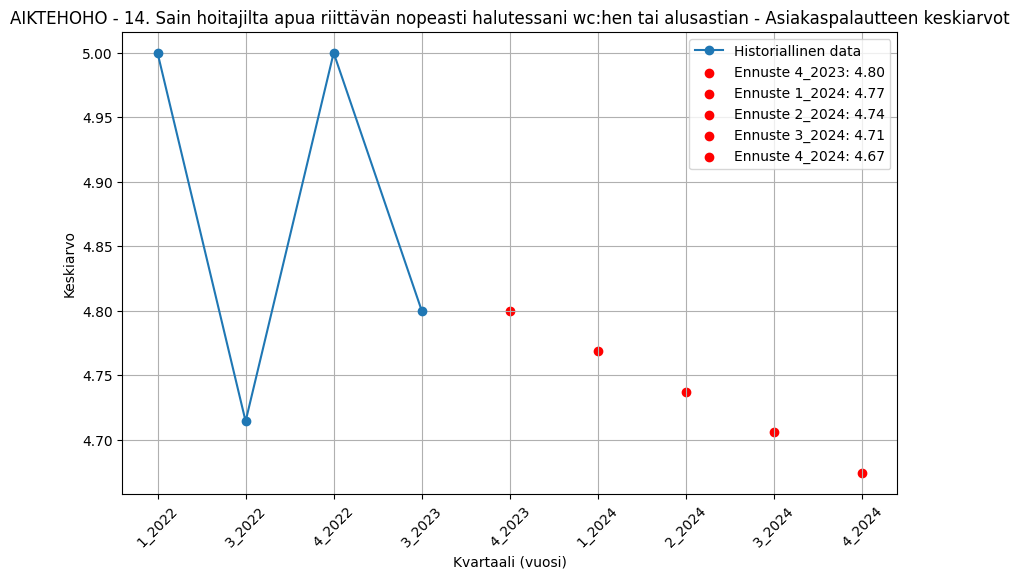

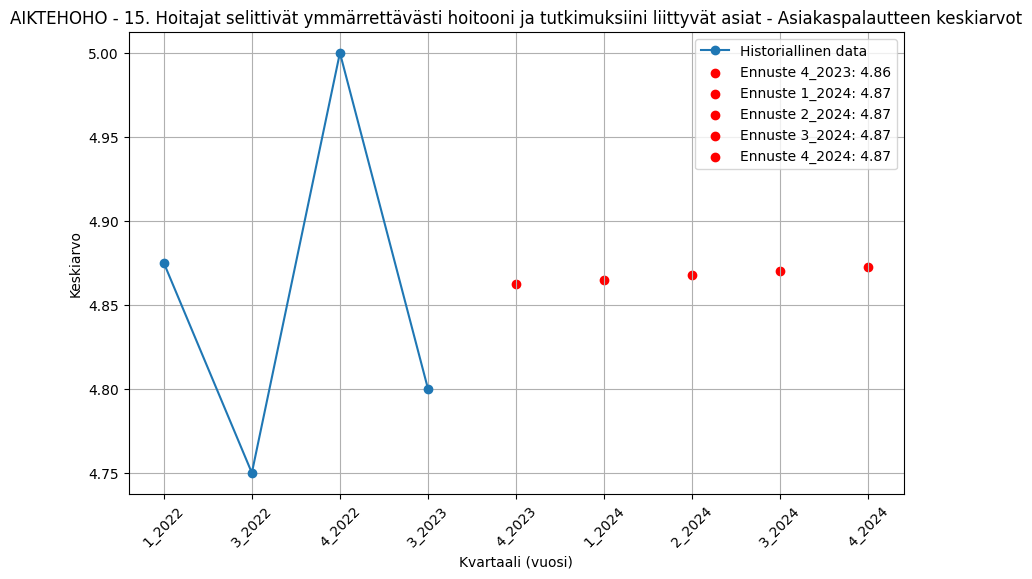

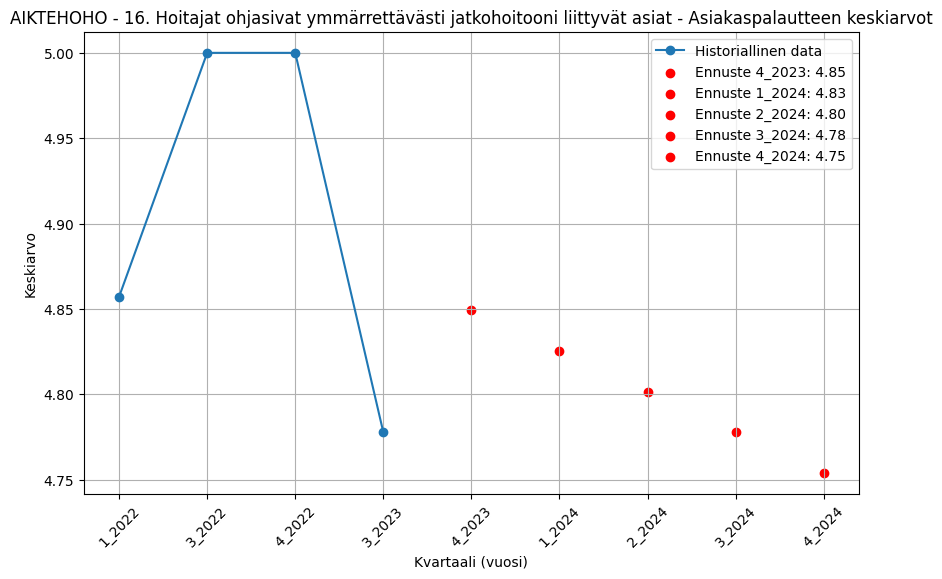

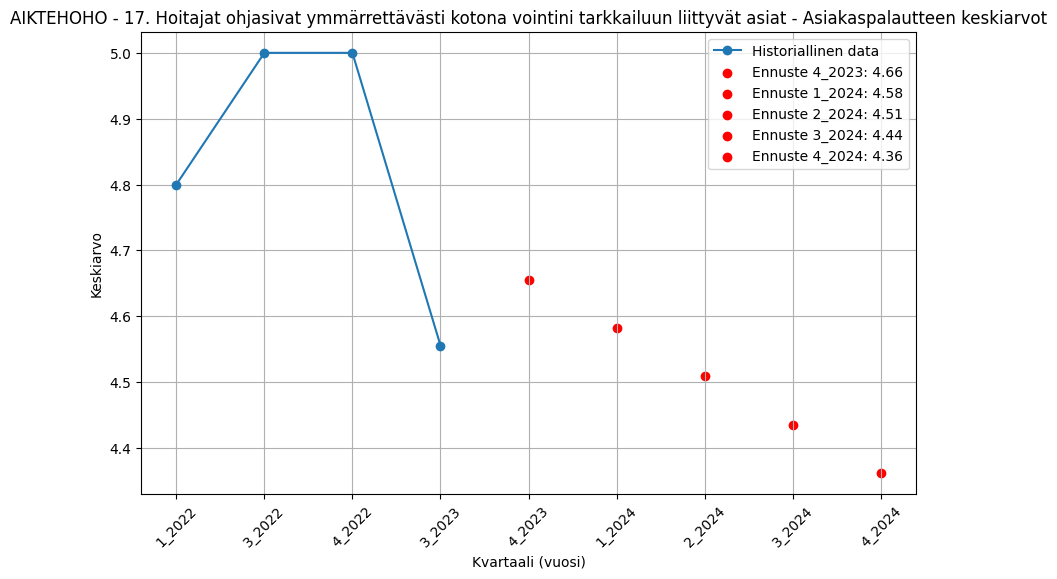

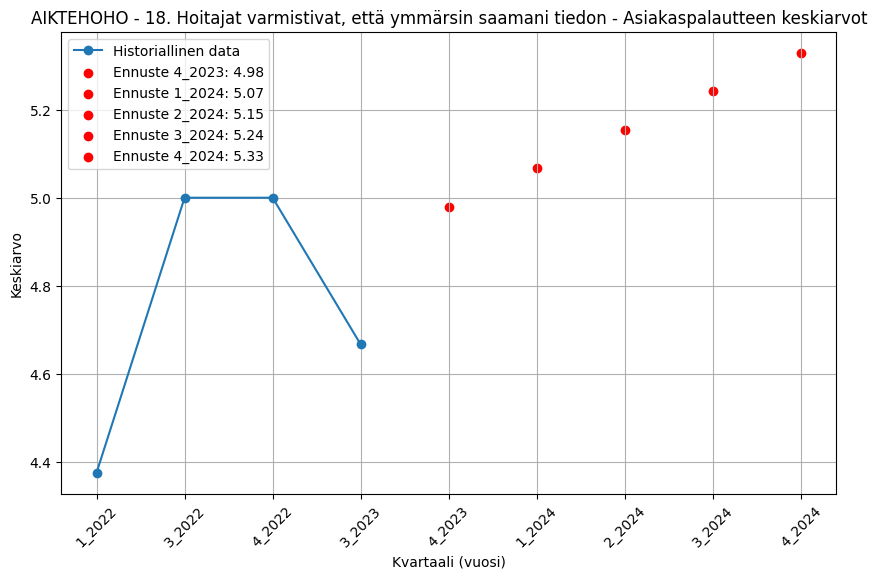

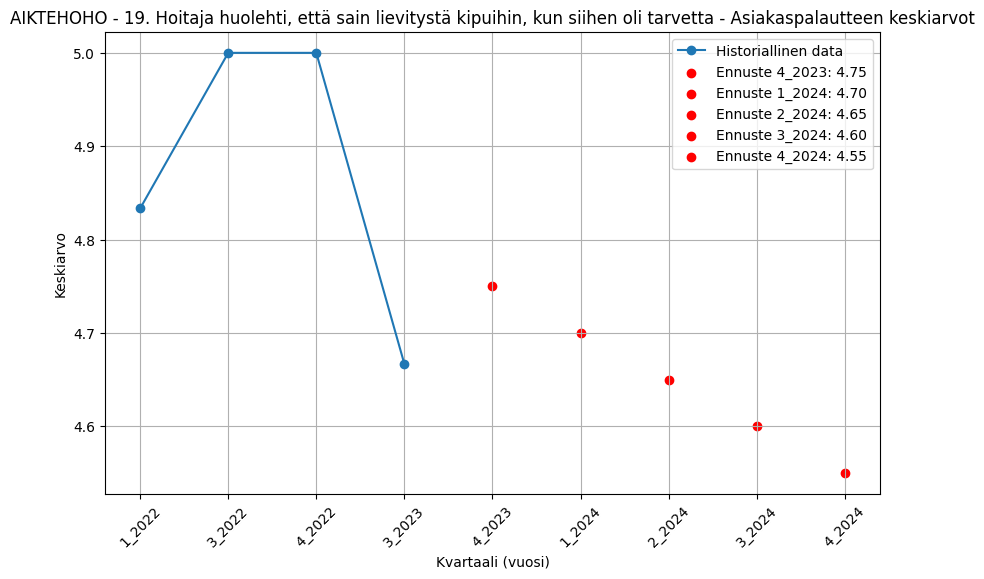

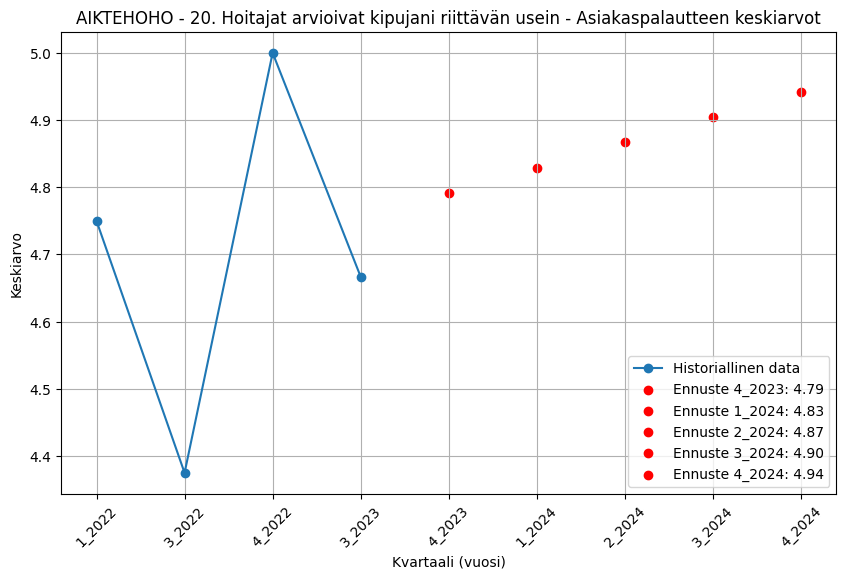

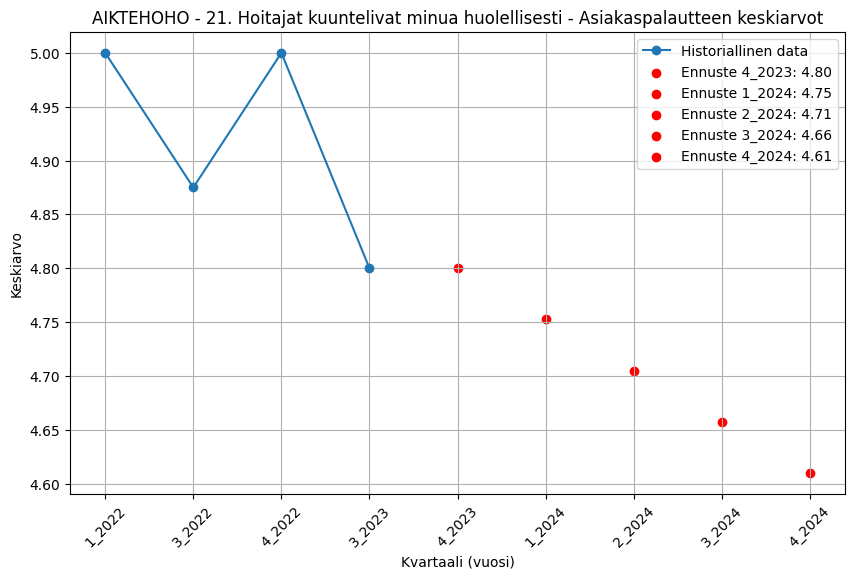

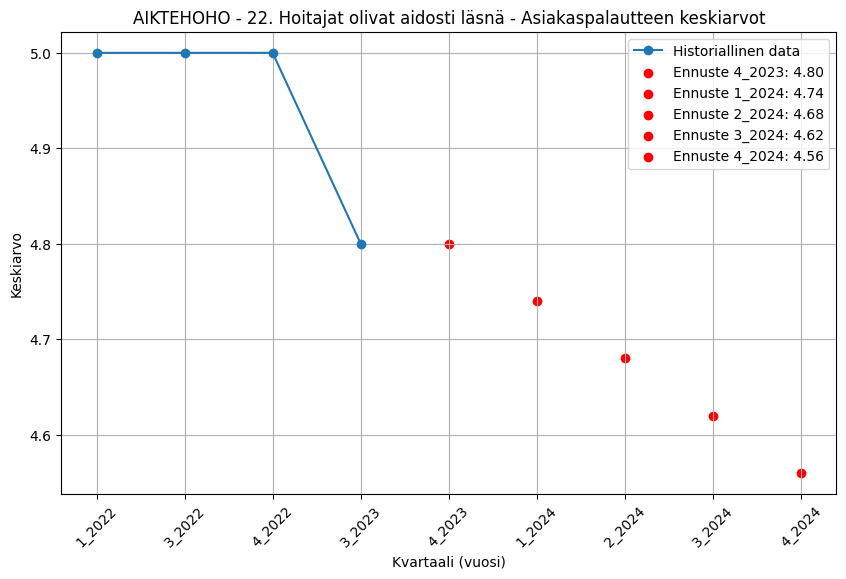

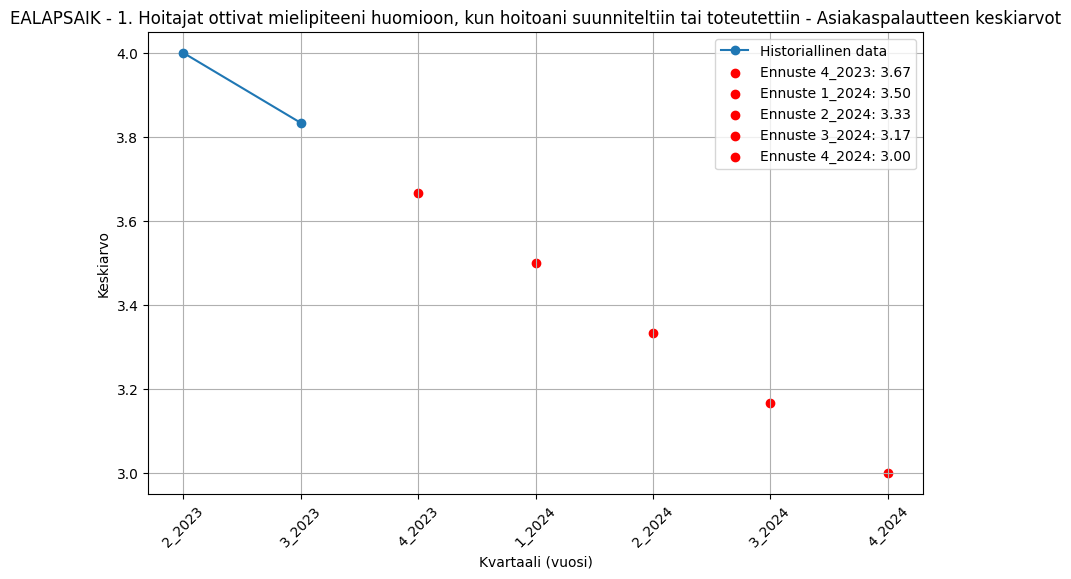

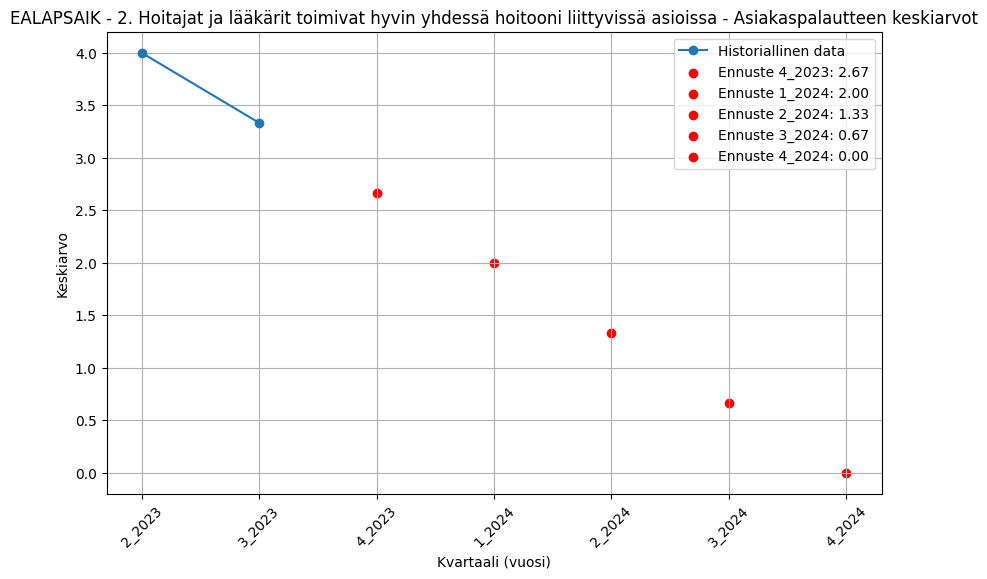

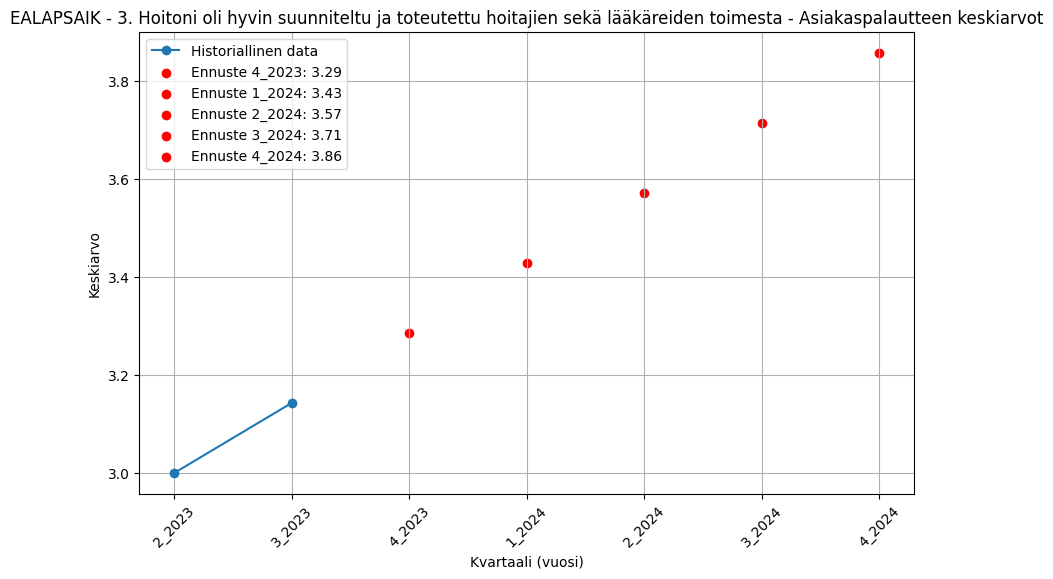

Ei riittävästi dataa ennustamiseen kysymykselle 4. Hoitajat pyysivät minulta anteeksi, jos hoidossani tapahtui virhe yksikölle EALAPSAIK.
Ei riittävästi dataa ennustamiseen kysymykselle 5. Hoitajat puuttuivat epäkohtaan, josta mainitsin heille yksikölle EALAPSAIK.
Ei riittävästi dataa ennustamiseen kysymykselle 6. Hoitajat kertoivat minulle uuden lääkkeen antamisen yhteydessä, miksi lääkettä annetaan yksikölle EALAPSAIK.
Ei riittävästi dataa ennustamiseen kysymykselle 7. Hoitajat kertoivat minulle saamieni lääkkeiden mahdollisista sivuvaikutuksista yksikölle EALAPSAIK.
Ei riittävästi dataa ennustamiseen kysymykselle 8. Hoitajat puhuivat arkaluontoisista asioista siten, etteivät ulkopuoliset kuulleet niitä yksikölle EALAPSAIK.


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

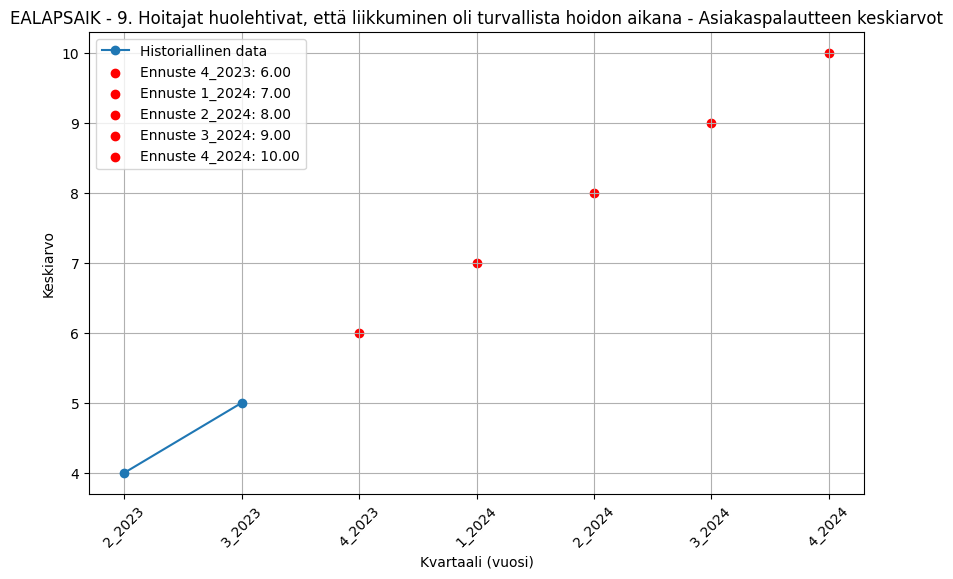

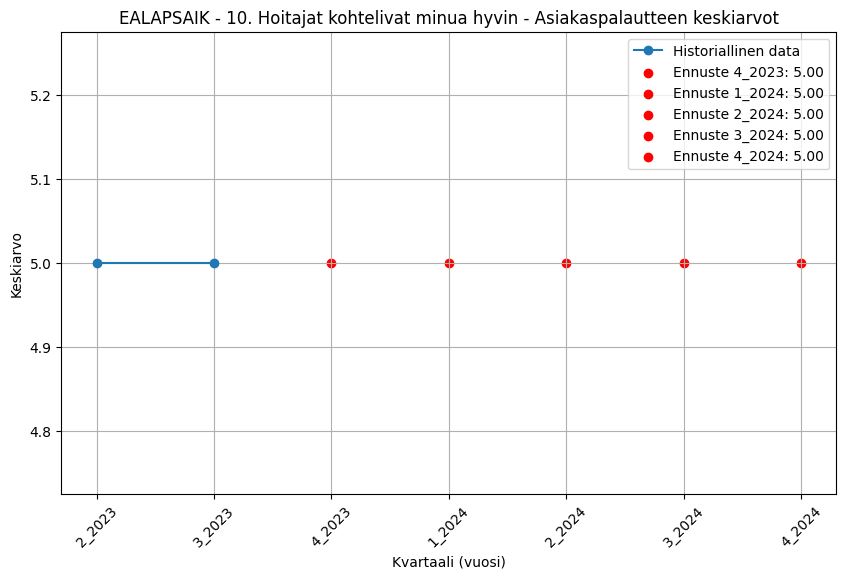

Ei riittävästi dataa ennustamiseen kysymykselle 11. Hoitajat huolehtivat, etteivät hoito ja/tai tutkimukset aiheuttaneet minulle noloja tai kiusallisia tilanteita yksikölle EALAPSAIK.


<Figure size 1000x600 with 0 Axes>

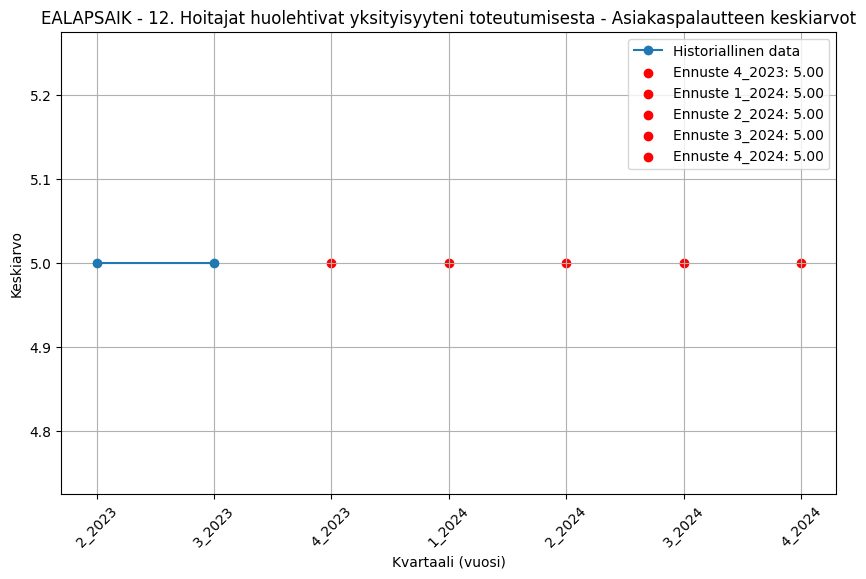

Ei riittävästi dataa ennustamiseen kysymykselle 13. Sain tarvitsemani avun hoitajilta riittävän nopeasti yksikölle EALAPSAIK.
Ei riittävästi dataa ennustamiseen kysymykselle 14. Sain hoitajilta apua riittävän nopeasti halutessani wc:hen tai alusastian yksikölle EALAPSAIK.
Ei riittävästi dataa ennustamiseen kysymykselle 15. Hoitajat selittivät ymmärrettävästi hoitooni ja tutkimuksiini liittyvät asiat yksikölle EALAPSAIK.
Ei riittävästi dataa ennustamiseen kysymykselle 16. Hoitajat ohjasivat ymmärrettävästi jatkohoitooni liittyvät asiat yksikölle EALAPSAIK.
Ei riittävästi dataa ennustamiseen kysymykselle 17. Hoitajat ohjasivat ymmärrettävästi kotona vointini tarkkailuun liittyvät asiat yksikölle EALAPSAIK.
Ei riittävästi dataa ennustamiseen kysymykselle 18. Hoitajat varmistivat, että ymmärsin saamani tiedon yksikölle EALAPSAIK.
Ei riittävästi dataa ennustamiseen kysymykselle 19. Hoitaja huolehti, että sain lievitystä kipuihin, kun siihen oli tarvetta yksikölle EALAPSAIK.
Ei riittävästi d

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

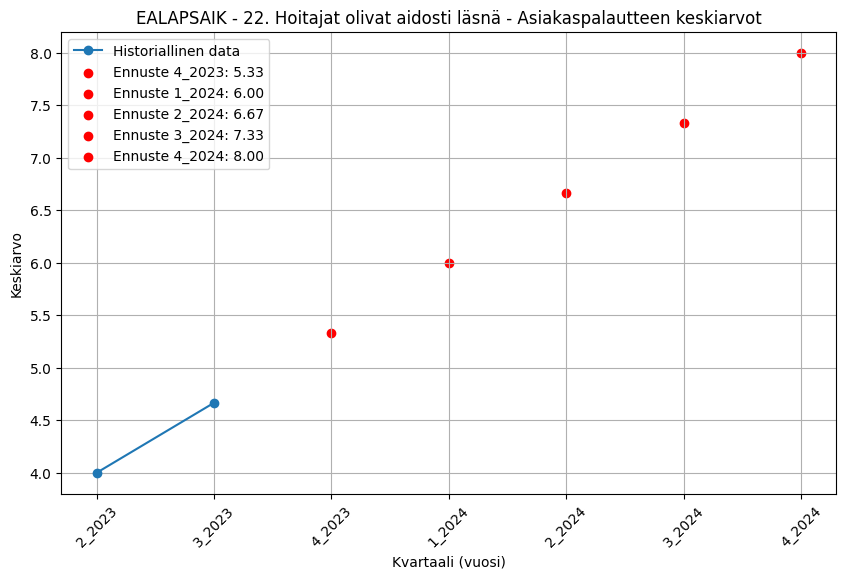

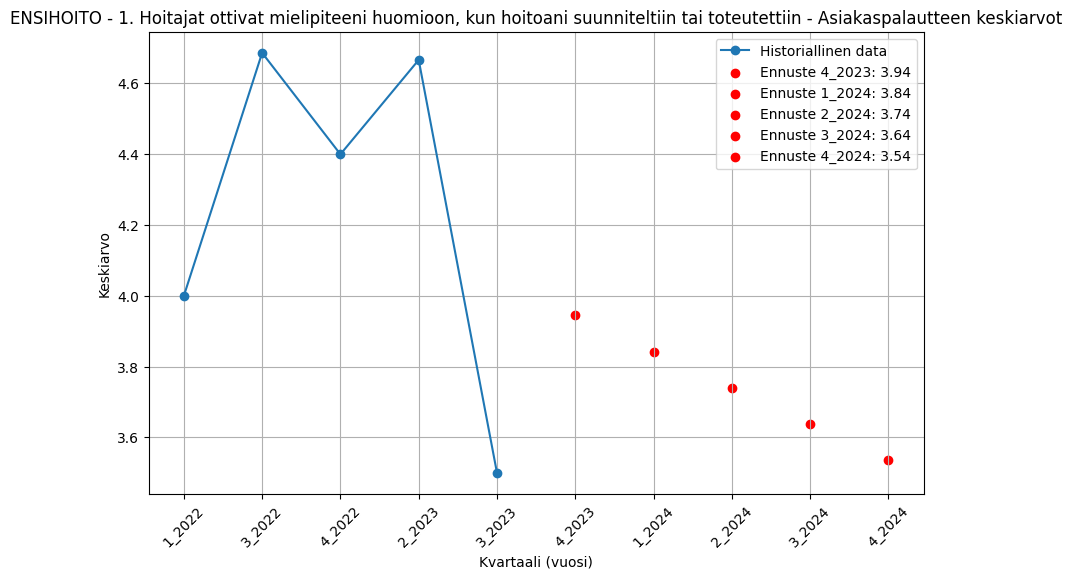

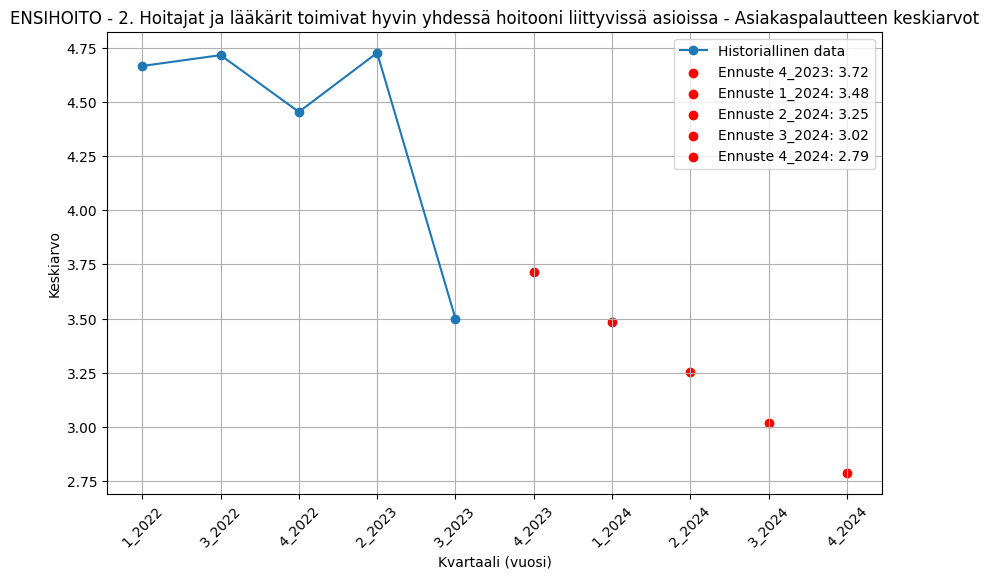

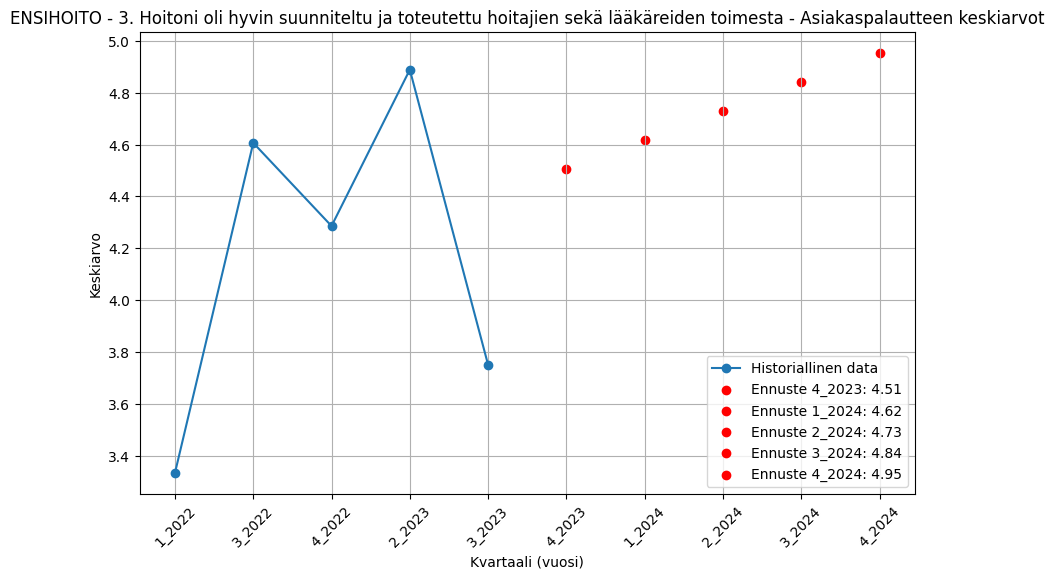

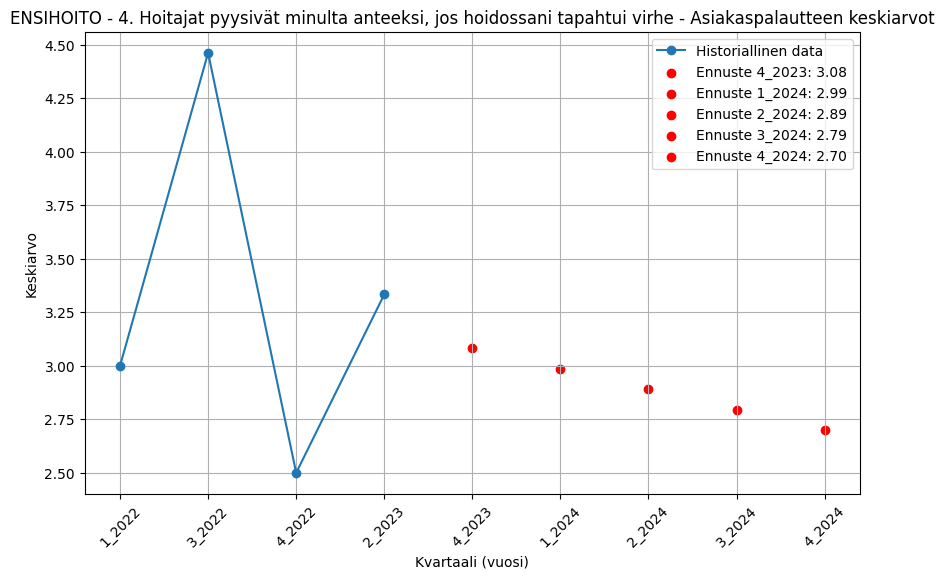

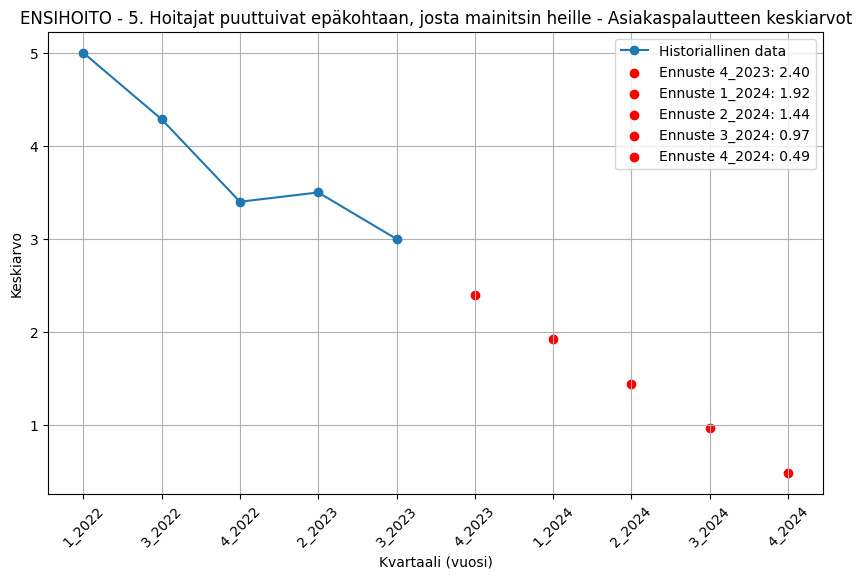

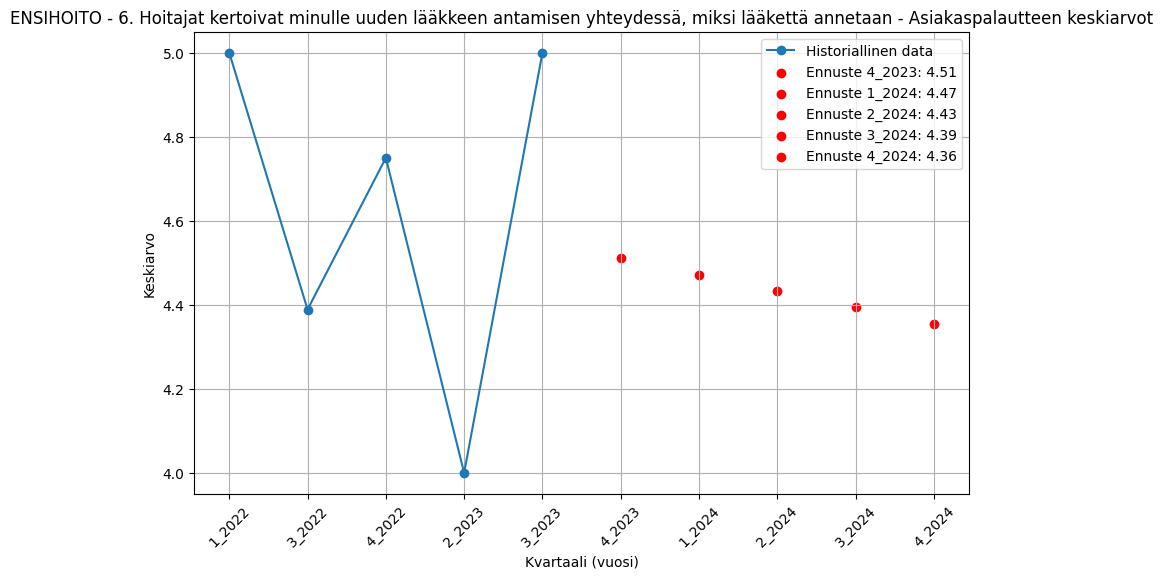

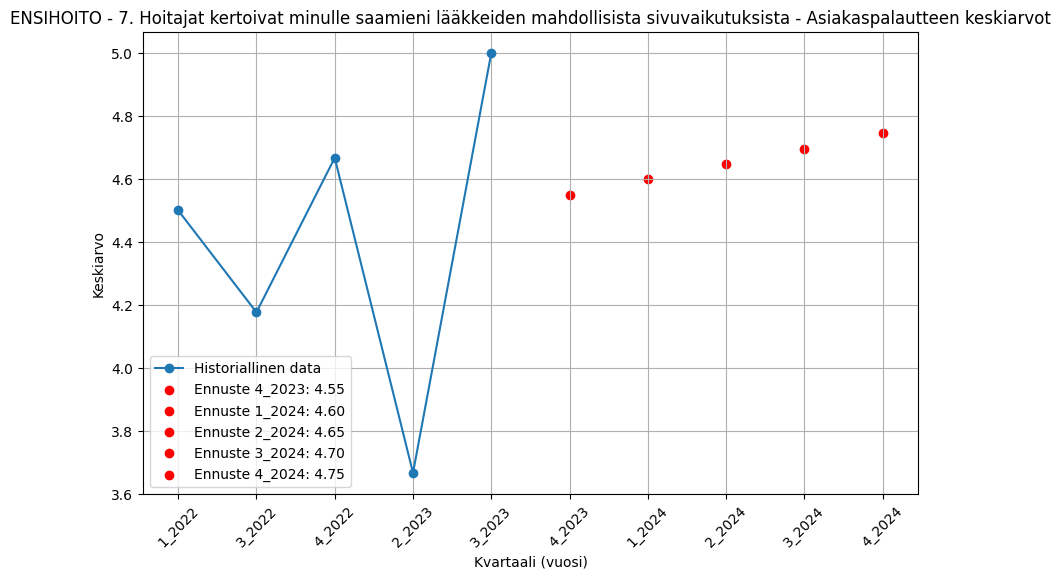

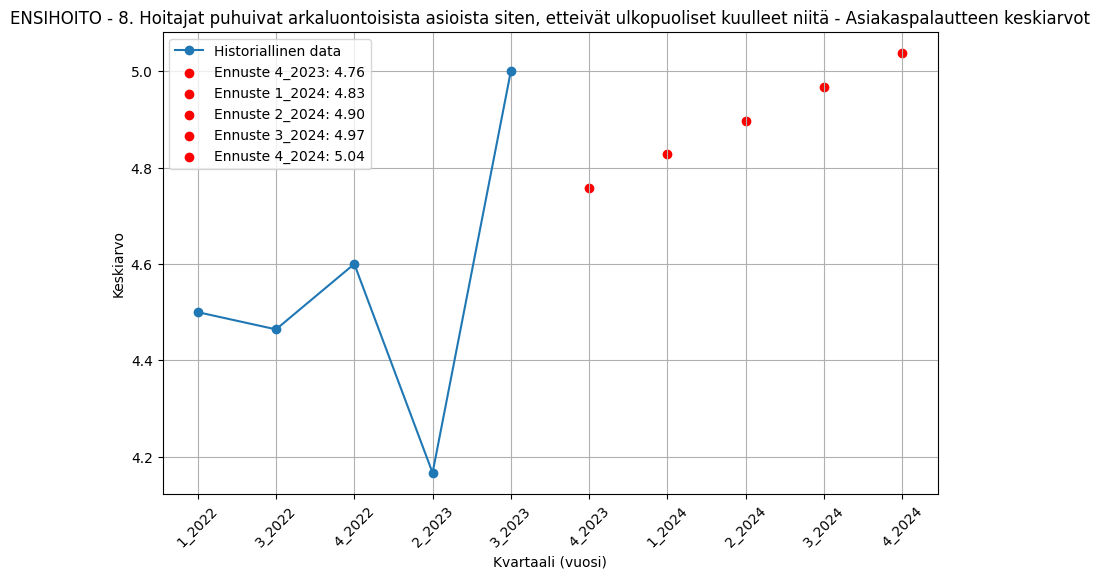

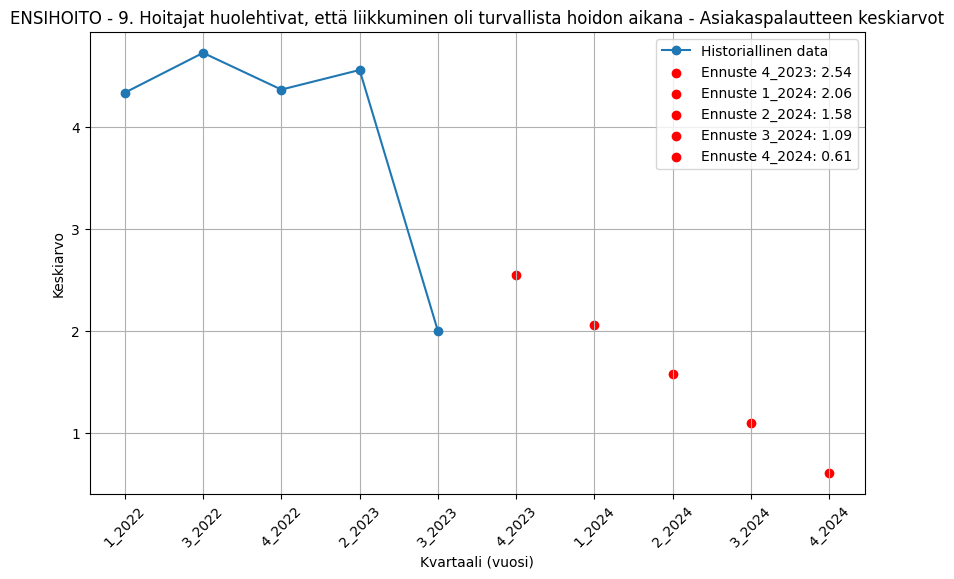

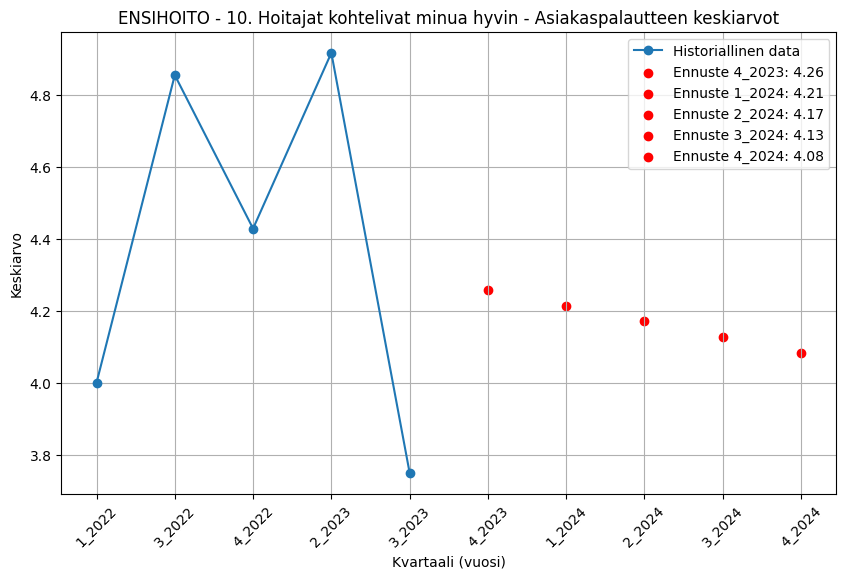

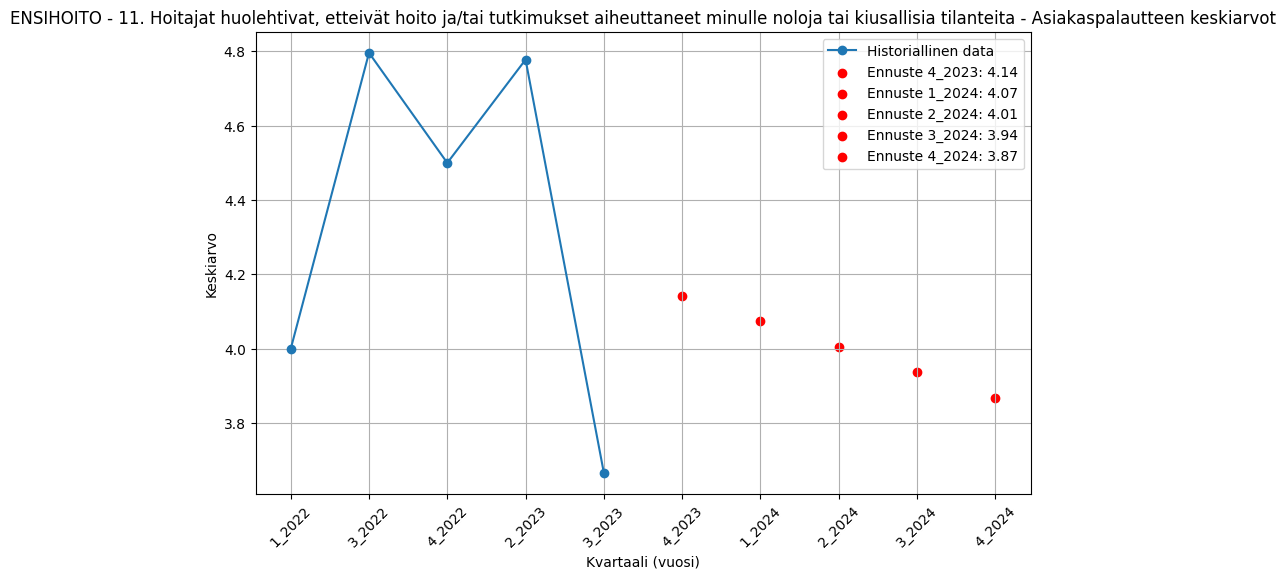

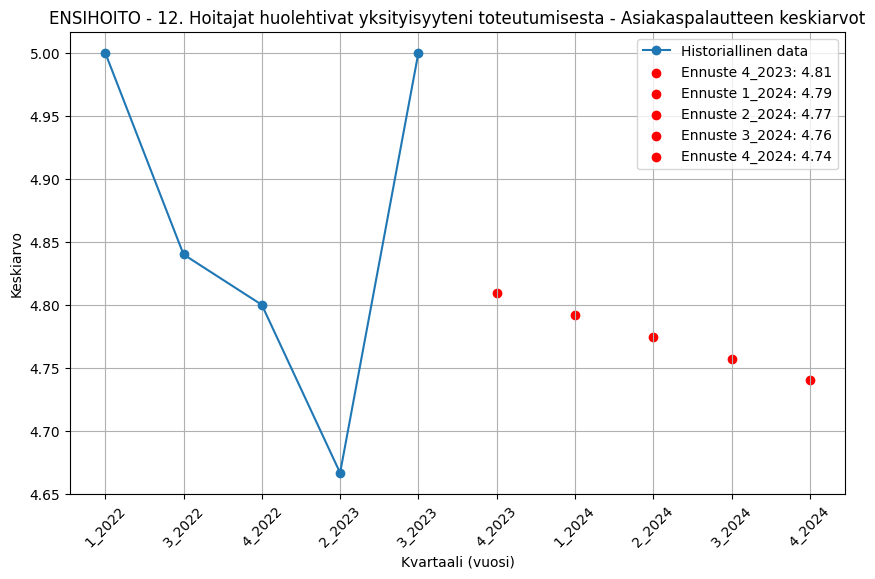

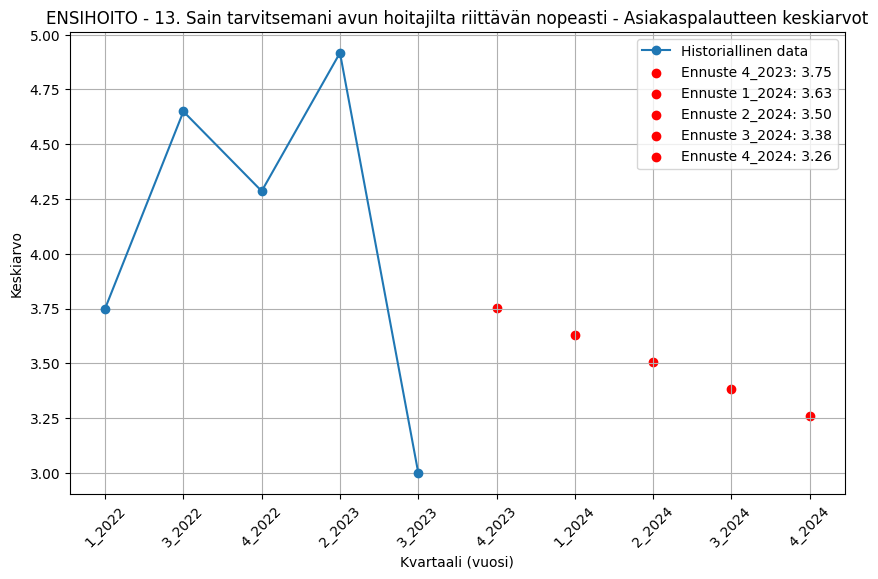

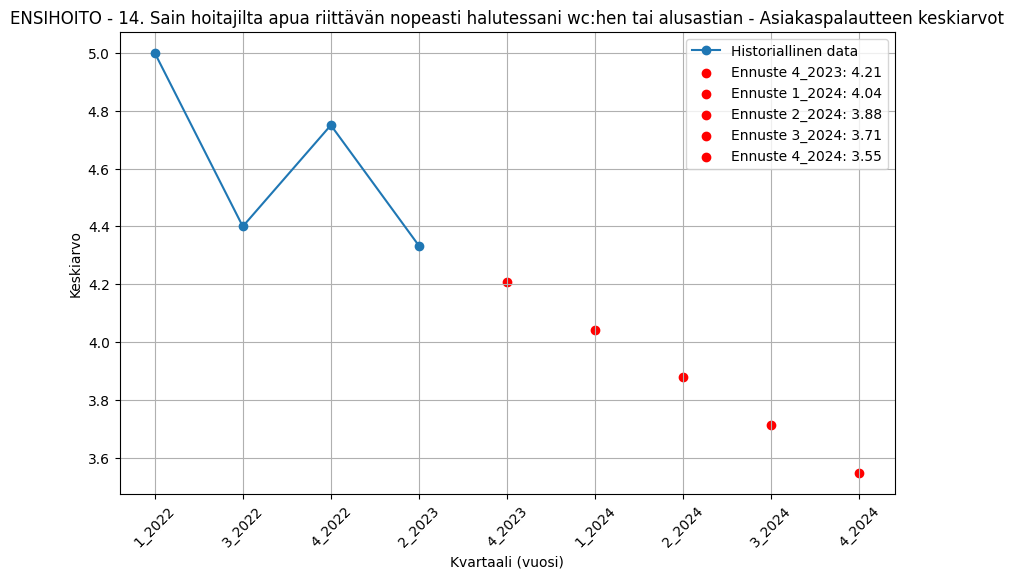

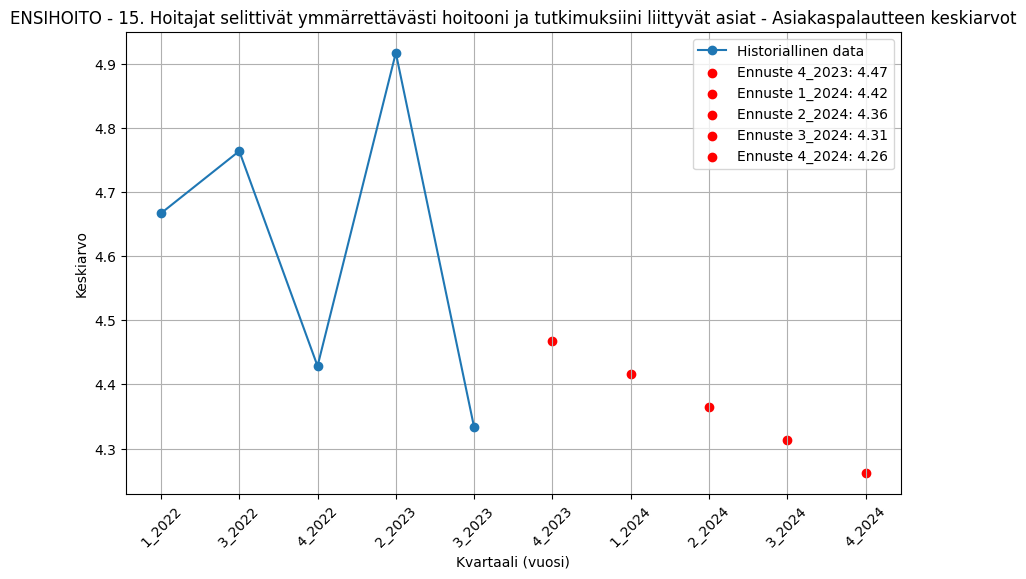

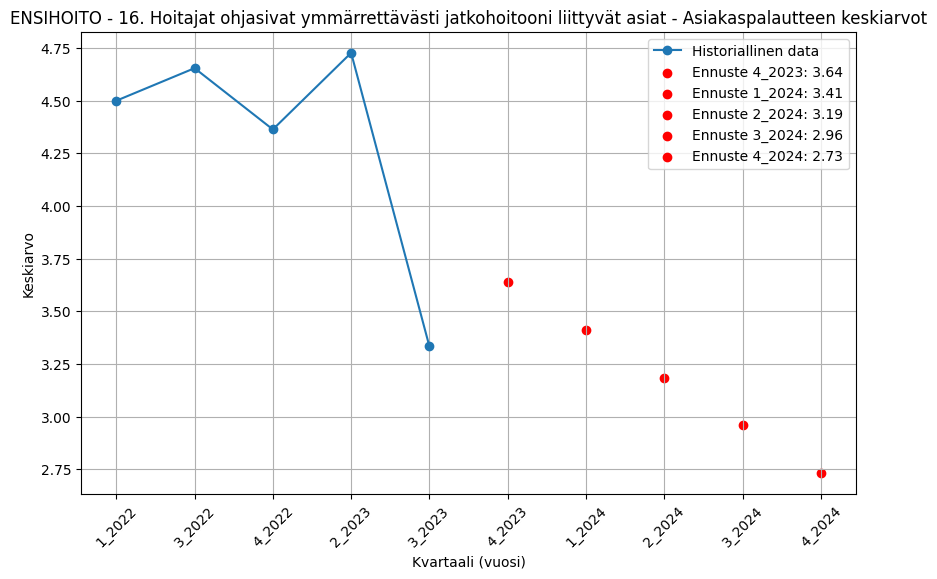

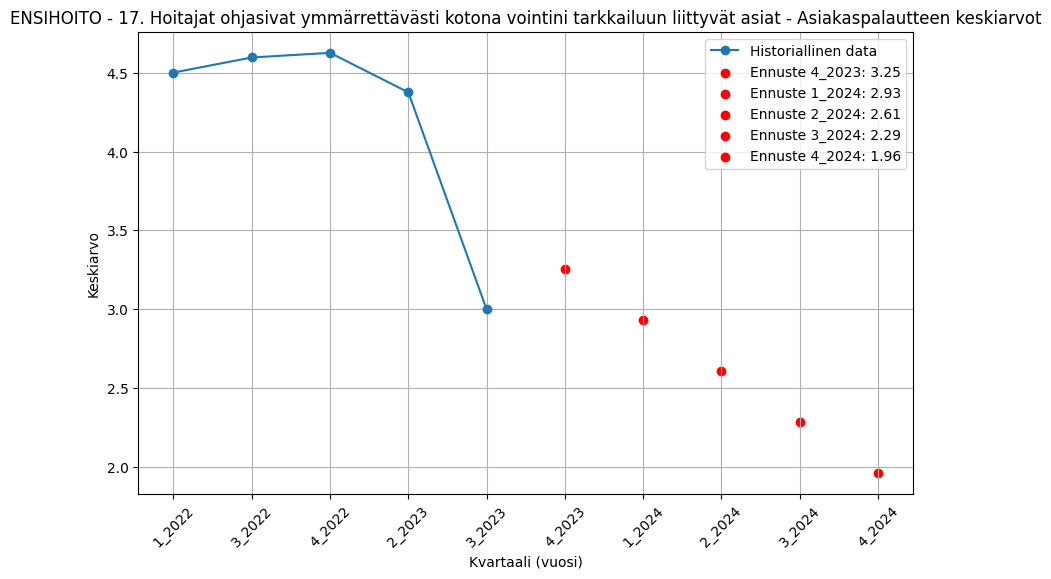

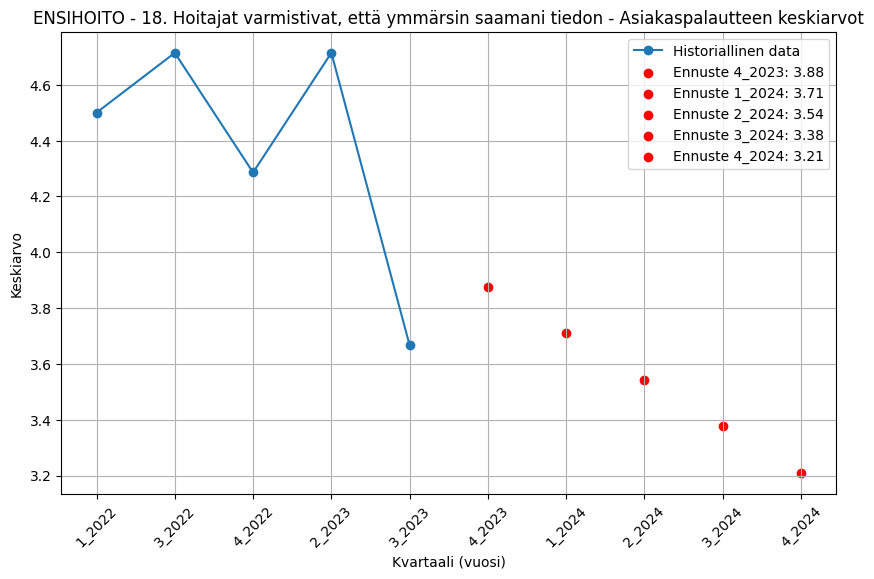

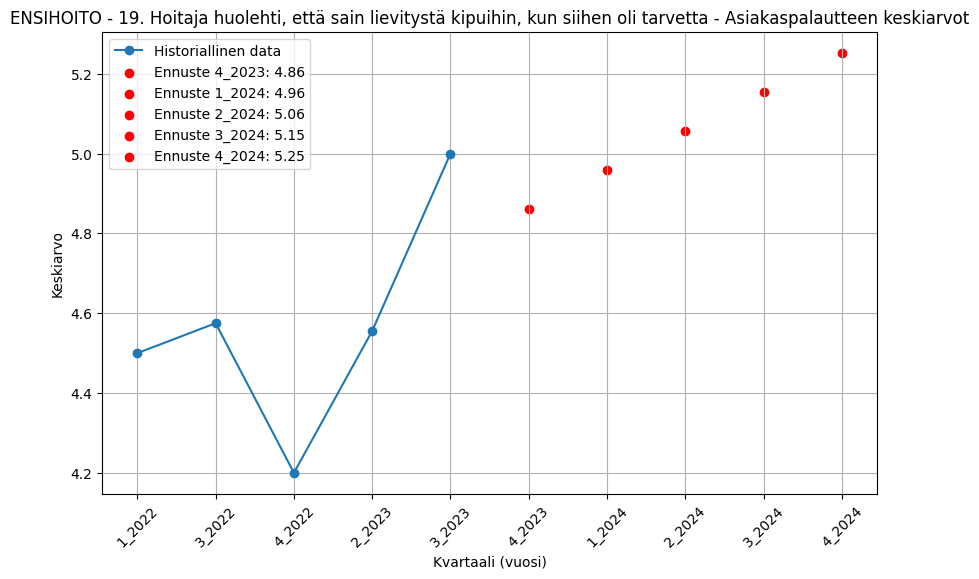

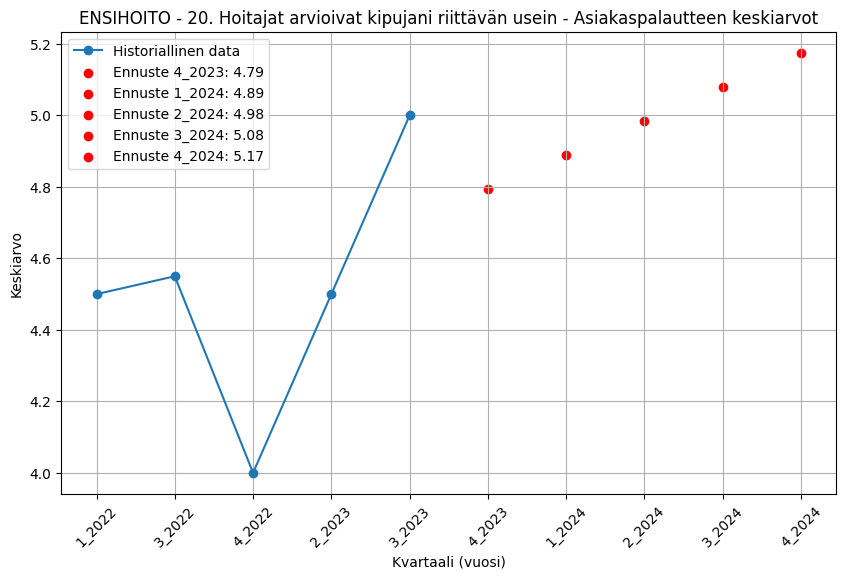

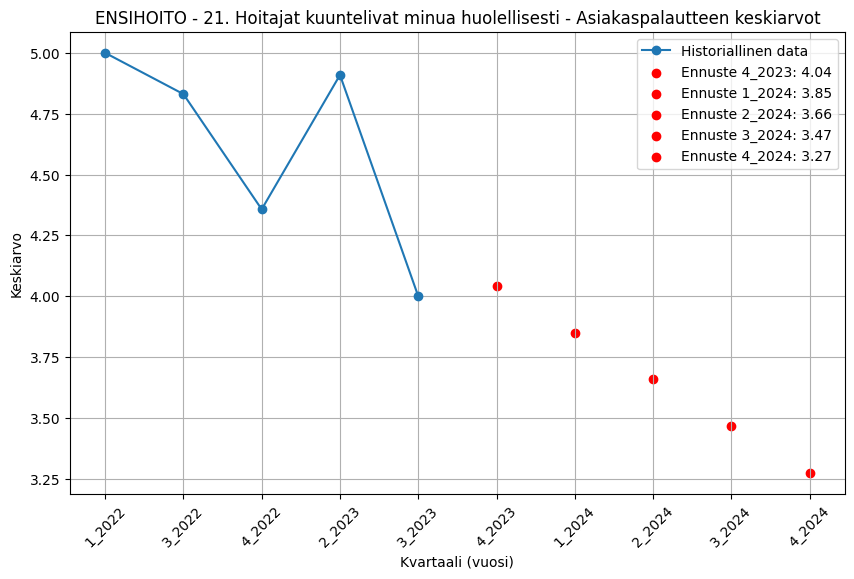

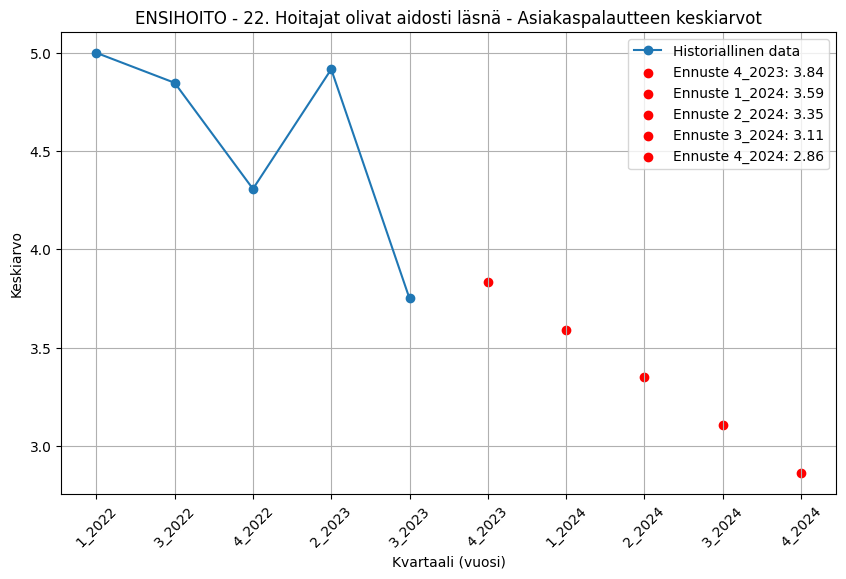

In [9]:
from sklearn.linear_model import LinearRegression

# Data yksiköille
units = ["AIKTEHOHO", "EALAPSAIK", "ENSIHOITO"]
numeric_columns = [
    '1. Hoitajat ottivat mielipiteeni huomioon, kun hoitoani suunniteltiin tai toteutettiin',
    '2. Hoitajat ja lääkärit toimivat hyvin yhdessä hoitooni liittyvissä asioissa',
    '3. Hoitoni oli hyvin suunniteltu ja toteutettu hoitajien sekä lääkäreiden toimesta',
    '4. Hoitajat pyysivät minulta anteeksi, jos hoidossani tapahtui virhe',
    '5. Hoitajat puuttuivat epäkohtaan, josta mainitsin heille',
    '6. Hoitajat kertoivat minulle uuden lääkkeen antamisen yhteydessä, miksi lääkettä annetaan',
    '7. Hoitajat kertoivat minulle saamieni lääkkeiden mahdollisista sivuvaikutuksista',
    '8. Hoitajat puhuivat arkaluontoisista asioista siten, etteivät ulkopuoliset kuulleet niitä',
    '9. Hoitajat huolehtivat, että liikkuminen oli turvallista hoidon aikana',
    '10. Hoitajat kohtelivat minua hyvin',
    '11. Hoitajat huolehtivat, etteivät hoito ja/tai tutkimukset aiheuttaneet minulle noloja tai kiusallisia tilanteita',
    '12. Hoitajat huolehtivat yksityisyyteni toteutumisesta',
    '13. Sain tarvitsemani avun hoitajilta riittävän nopeasti',
    '14. Sain hoitajilta apua riittävän nopeasti halutessani wc:hen tai alusastian',
    '15. Hoitajat selittivät ymmärrettävästi hoitooni ja tutkimuksiini liittyvät asiat',
    '16. Hoitajat ohjasivat ymmärrettävästi jatkohoitooni liittyvät asiat',
    '17. Hoitajat ohjasivat ymmärrettävästi kotona vointini tarkkailuun liittyvät asiat',
    '18. Hoitajat varmistivat, että ymmärsin saamani tiedon',
    '19. Hoitaja huolehti, että sain lievitystä kipuihin, kun siihen oli tarvetta',
    '20. Hoitajat arvioivat kipujani riittävän usein',
    '21. Hoitajat kuuntelivat minua huolellisesti',
    '22. Hoitajat olivat aidosti läsnä'
]

# Splitting 'KVARTAALI JA VUOSI' into 'KVARTAALI' and 'VUOSI'
data[['KVARTAALI', 'VUOSI']] = data['KVARTAALI JA VUOSI\n(ESIM. 1_2020)'].str.split('_', expand=True)
data['KVARTAALI'] = data['KVARTAALI'].astype(int)
data['VUOSI'] = data['VUOSI'].astype(int)

# Muunnetaan kvartaali ja vuosi tekstiksi, jotta pysyy muodossa "Kvartaali_Vuosi"
data['KvartaaliVuosi'] = data['KVARTAALI'].astype(str) + "_" + data['VUOSI'].astype(str)

# Ennustus ja visualisointi jokaiselle yksikölle ja kysymykselle
for unit in units:
    unit_data = data[data["YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä"] == unit]
    
    # Visualisoidaan jokaisen kysymyksen aikasarja ja ennuste
    for question in numeric_columns:
        plt.figure(figsize=(10, 6))
        
        # Ryhmitellään keskiarvot kvartaaleittain ja vuosittain
        avg_data = unit_data.groupby(["VUOSI", "KVARTAALI"])[question].mean().reset_index()
        avg_data['KvartaaliVuosi'] = avg_data['KVARTAALI'].astype(str) + "_" + avg_data['VUOSI'].astype(str)  # Yhdistetään uudelleen tekstiksi
        
        # Poistetaan rivit, joissa on NaN-arvoja
        avg_data = avg_data.dropna(subset=[question])

        # Tarkistetaan, että datassa on riittävästi pisteitä
        if avg_data.shape[0] > 1:
            X = np.arange(avg_data.shape[0]).reshape(-1, 1)  # X-akselin arvot järjestetään numeerisena
            y = avg_data[question]
            
            # Lineaarinen regressiomalli
            model = LinearRegression()
            model.fit(X, y)
            
            # Ennustetaan kvartaaleille Q4/2023 ja koko vuodelle 2024
            future_quarters = np.arange(len(X), len(X) + 5).reshape(-1, 1)  # Viisi seuraavaa kvartaalia
            predictions = model.predict(future_quarters)
            forecast_labels = ["4_2023", "1_2024", "2_2024", "3_2024", "4_2024"]  # Ennustetut kvartaalit

            # Plotataan vanhat arvot ja ennusteet
            plt.plot(avg_data['KvartaaliVuosi'], y, marker='o', label="Historiallinen data")
            for i, prediction in enumerate(predictions):
                plt.scatter(forecast_labels[i], prediction, color='red', label=f"Ennuste {forecast_labels[i]}: {prediction:.2f}")

            plt.title(f"{unit} - {question} - Asiakaspalautteen keskiarvot")
            plt.xlabel("Kvartaali (vuosi)")
            plt.ylabel("Keskiarvo")
            plt.xticks(rotation=45)
            plt.legend()
            plt.grid()
            plt.show()
        else:
            print(f"Ei riittävästi dataa ennustamiseen kysymykselle {question} yksikölle {unit}.")
